In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import warnings

import networkx as nx
# from mpl_toolkits.basemap import Basemap as Basemap
from networkx.algorithms.community import girvan_newman, modularity

# from google.colab import drive
# drive.mount('/content/gdrive')

warnings.filterwarnings("ignore")
%matplotlib inline

# Data Loading

In [2]:
airline_data = pd.read_csv('flight_data/Combined_Flights_2022.csv')
airline_data

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,False,False,1133,1123.0,0.0,-10.0,...,1140.0,1220.0,8.0,1245,-17.0,0.0,-2.0,1200-1259,1,0
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,False,False,732,728.0,0.0,-4.0,...,744.0,839.0,9.0,849,-1.0,0.0,-1.0,0800-0859,2,0
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1529,1514.0,0.0,-15.0,...,1535.0,1622.0,14.0,1639,-3.0,0.0,-1.0,1600-1659,2,0
3,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",IAH,GPT,False,False,1435,1430.0,0.0,-5.0,...,1446.0,1543.0,4.0,1605,-18.0,0.0,-2.0,1600-1659,2,0
4,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1135,1135.0,0.0,0.0,...,1154.0,1243.0,8.0,1245,6.0,0.0,0.0,1200-1259,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4078313,2022-03-31,Republic Airlines,MSY,EWR,False,True,1949,2014.0,25.0,25.0,...,2031.0,202.0,32.0,2354,NaN,NaN,NaN,2300-2359,5,1
4078314,2022-03-17,Republic Airlines,CLT,EWR,True,False,1733,1817.0,44.0,44.0,...,NaN,NaN,NaN,1942,NaN,NaN,NaN,1900-1959,3,0
4078315,2022-03-08,Republic Airlines,ALB,ORD,False,False,1700,2318.0,378.0,378.0,...,2337.0,52.0,7.0,1838,381.0,1.0,12.0,1800-1859,3,0
4078316,2022-03-25,Republic Airlines,EWR,PIT,False,True,2129,2322.0,113.0,113.0,...,2347.0,933.0,6.0,2255,NaN,NaN,NaN,2200-2259,2,1


# Exploratory Data Analysis

## Data Quality

In [3]:
airline_data.shape

(4078318, 61)

In [4]:
airline_data.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [5]:
null_counts = airline_data.isna().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)

DepTime                 120433
DepDelayMinutes         120495
DepDelay                120495
ArrTime                 124239
ArrDelayMinutes         133402
AirTime                 133402
ActualElapsedTime       133402
Tail_Number              26795
DepDel15                120495
DepartureDelayGroups    120495
TaxiOut                 122666
WheelsOff               122666
WheelsOn                124242
TaxiIn                  124242
ArrDelay                133402
ArrDel15                133402
ArrivalDelayGroups      133402
dtype: int64


# Definition of Terms

<span style="font-size: 16px">
    <center><b>Table 1. Summary of different network modeling approaches. (Chauhan et al.)</b></center>
</span>

| Network | Description | Insights |
| :------- | :----------- | :-------- |
| AFCN    | Node: airports;edge: two airports have an edge between them if there is at least one flight between them; edge weight: number of flights between the airports. | AFCN helps to analyze the airline schedules. The analysis of AFCN yields the busiest airports and airport pairs, which have the highest traffic between them. |
| AFDN    | Similar to AFCN but here we consider only delayed flights. | AFDN helps to analyze the airline historical operational data. It helps to identify the airports and airport pairs which caused the biggest disruptions. |
| FCCN    | Node: flights; edge: shared flight connection; weight: frequency of connection. | FCCN helps to analyze the airline schedules. It gives us flights and flight connections, which have the potential to cause disruption to several others. |
| FCDN    | It is similar to FCCN except that it considers only delayed flights as nodes and flight connections with delay propagation only. | FCDN helps to analyze the airline historical operational data. It helps to identify flights and flight connections, which caused the biggest disruptions in the network. |

<span style="font-size: 16px">
    <center><b>Table 2. Network science techniques/properties and insights drawn from them. (Chauhan et al.)</b></center>
</span>

| Property                  | Definition                                                                      | Insights                                                                                                       |
| :------------------------ | :------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------- |
| Network                   | Network is a set of nodes and set of links where nodes represent some objects and links capture some type of relationship between those objects. | It is used to represent and analyze data with non-linear relationships.                                         |
| Degree distribution       | Degree distribution represents the probability distribution of the degree over the entire network. | It provides us with structural insights about the network.                                                      |
| Centrality                | It helps to identify the central elements of the network depending on their impact on other elements. | This concept helps to identify the most influential flights, airports, and connections that have a significant impact on other flights, in terms of delay propagation. |
| Out-degree centrality     | It helps to identify the important nodes based on their out-degree. | This concept helps to identify the flights and airports that have a significant impact on other flights.        |
| Node betweenness centrality | It helps to identify important nodes based on the flow of information through them. | This concept helps to identify influential flights and airports through which the highest delays are either propagated or can potentially be propagated. |
| Edge betweenness centrality | It helps to identify important edges based on the flow of information through them. | This concept helps to identify flight connections and airport-pairs through which the highest delays are either propagated or can potentially be propagated. |
| Percolation               | It is a study of the removal of nodes/edges of a network and their effect on the connectivity of the network. | In the airline scenario, when applied to a delay network for node percolation, it tells us which flights delay should be avoided to avoid big disruptions. |
| Diameter                  | The diameter of a connected network is defined as the largest shortest distance between any two nodes, and the diameter of a disconnected network is infinite. | This concept tells us about the minimum number of flights required for the propagation of delays from any part of the network to any other part. |
| Small-world effect        | When one can reach from any node of the network to any other node in the network in a few steps, then that network is said to exhibit the small-world effect. | In an airline network, if the small-world effect occurs in the network, it is susceptible to big disruptions because delays can propagate to the entire network with a few flight delays. |
| Density                   | It is defined as the ratio of the number of links in the network to the total number of possible links in the network. | This is a good metric to compare the different layers of the multi-task fully convolutional network (MFCN).     |

<span style="font-size: 16px">
    <center><b>Table 3. Airline data description.</b></center>
</span>

| Name           | Description                                                                               |
| :------------- | :---------------------------------------------------------------------------------------- |
| Flight number  | This is the number assigned to each flight and it might not be unique.                    |
| Origin airport | This is the airport from where the flight takes off.                                      |
| Departure airport | This is the airport where the flight lands.                                              |
| STA            | This is the scheduled time of arrival of the flight.                                       |
| ATA            | This is the actual time of arrival of the flight.                                          |
| STD            | This is the scheduled time of departure of the flight.                                      |
| ATD            | This is the actual time of departure of the flight.                                        |

In [6]:
# Select important columns
use_cols = ['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled',
            'Diverted', 'CRSDepTime', 'DepTime', 'DepDelayMinutes',
            'CRSArrTime', 'ArrTime', 'ArrDelayMinutes', 'Tail_Number',
            'Flight_Number_Marketing_Airline']

# Apply selected columns
df = airline_data[use_cols]

# Rename columns
df = df.rename(columns={'FlightDate': 'Date',
                        'CRSDepTime': 'STD',
                        'DepTime': 'ATD',
                        'CRSArrTime': 'STA',
                        'ArrTime': 'ATA',
                        'DepDelayMinutes': 'DepDelay',
                        'ArrDelayMinutes': 'ArrDelay',
                        'Flight_Number_Marketing_Airline': 'Flight_Number'})
df

,Date,Airline,Origin,Dest,Cancelled,Diverted,STD,ATD,DepDelay,STA,ATA,ArrDelay,Tail_Number,Flight_Number
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,False,False,1133,1123.0,0.0,1245,1228.0,0.0,N21144,4301
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,False,False,732,728.0,0.0,849,848.0,0.0,N16170,4299
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1529,1514.0,0.0,1639,1636.0,0.0,N21144,4298
3,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",IAH,GPT,False,False,1435,1430.0,0.0,1605,1547.0,0.0,N11184,4296
4,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1135,1135.0,0.0,1245,1251.0,6.0,N17146,4295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4078313,2022-03-31,Republic Airlines,MSY,EWR,False,True,1949,2014.0,25.0,2354,234.0,NaN,N745YX,3621
4078314,2022-03-17,Republic Airlines,CLT,EWR,True,False,1733,1817.0,44.0,1942,NaN,NaN,N654RW,3437
4078315,2022-03-08,Republic Airlines,ALB,ORD,False,False,1700,2318.0,378.0,1838,59.0,381.0,N733YX,3413
4078316,2022-03-25,Republic Airlines,EWR,PIT,False,True,2129,2322.0,113.0,2255,939.0,NaN,N647RW,3450


In [7]:
# time_columns = ['STD', 'ATD', 'STA', 'ATA']
# for col in time_columns:
#     df[col] = pd.to_datetime(df[col], format='%H%M', errors='coerce').dt.strftime('%H:%M')

In [8]:
# Assuming your DataFrame is named df
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime

# Define the start and end dates
start_date = pd.Timestamp('2022-05-01')
end_date = pd.Timestamp('2022-07-31')

# Filter the DataFrame to include only the data within the specified date range
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# selected_airlines = ['Delta Air Lines Inc.', 'American Airlines Inc.', 'Southwest Airlines Co.', 'United Air Lines Inc.']
selected_airlines = ['United Air Lines Inc.']
df_flight = filtered_df[filtered_df['Airline'].isin(selected_airlines)]
df_flight

,Date,Airline,Origin,Dest,Cancelled,Diverted,STD,ATD,DepDelay,STA,ATA,ArrDelay,Tail_Number,Flight_Number
1183316,2022-07-31,United Air Lines Inc.,ORD,DEN,False,False,1040,1039.0,0.0,1222,1203.0,0.0,N69818,2684
1183317,2022-07-31,United Air Lines Inc.,PHL,ORD,False,False,813,804.0,0.0,934,903.0,0.0,N66808,2684
1183318,2022-07-31,United Air Lines Inc.,ORD,SAN,False,False,1316,1314.0,0.0,1537,1509.0,0.0,N463UA,2683
1183319,2022-07-31,United Air Lines Inc.,IAH,DCA,False,False,2001,1953.0,0.0,2359,2344.0,0.0,N23707,2682
1183320,2022-07-31,United Air Lines Inc.,DEN,SFO,False,False,1920,1952.0,32.0,2101,2119.0,18.0,N780UA,2681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456348,2022-06-15,United Air Lines Inc.,EWR,BOS,False,False,929,944.0,15.0,1050,1053.0,3.0,N23707,1953
2456349,2022-06-15,United Air Lines Inc.,LAS,DEN,False,False,1635,1626.0,0.0,1935,1932.0,0.0,N77525,1952
2456350,2022-06-15,United Air Lines Inc.,MCI,DEN,False,False,1717,1706.0,0.0,1808,1804.0,0.0,N847UA,1951
2456351,2022-06-15,United Air Lines Inc.,RAP,DEN,False,False,1110,1106.0,0.0,1227,1213.0,0.0,N892UA,1950


In [9]:
df_flight['Airline'].unique()

array(['United Air Lines Inc.'], dtype=object)

# Networkx Dataset Creation

## AFCN

In [10]:
# Group by Origin and Dest, then count the number of flights
df_AFCN = df_flight.groupby(['Origin', 'Dest']).size().reset_index(name='Flights')

# Display the aggregated DataFrame
display(df_AFCN)

,Origin,Dest,Flights
0,ABQ,DEN,227
1,ABQ,IAH,61
2,ABQ,ORD,31
3,ABQ,SFO,90
4,ALB,EWR,1
...,...,...,...
808,TUL,ORD,2
809,TUS,DEN,38
810,TUS,ORD,4
811,TVC,DEN,35


## AFDN

In [11]:
# Group by Origin and Dest, then count the number of flights
df_AFDN = (df_flight.loc[df_flight['DepDelay'] >= 15]
                    .groupby(['Origin', 'Dest'])
                    .size()
                    .reset_index(name='Flights'))

# Display the aggregated DataFrame
display(df_AFDN)

,Origin,Dest,Flights
0,ABQ,DEN,50
1,ABQ,IAH,7
2,ABQ,ORD,4
3,ABQ,SFO,14
4,ALB,ORD,47
...,...,...,...
781,TUL,IAH,10
782,TUS,DEN,9
783,TUS,ORD,2
784,TVC,DEN,7


In [12]:
def create_afcn(df, origin, destination):
    
    df_AFCN = df.groupby([origin, destination]).size().reset_index(name='Flights')
    return df_AFCN

## FCCN

In [13]:
# Assuming df_flight is your DataFrame
df_flight['node_name'] = (df_flight['Flight_Number'].astype(str) + '.' +
                          df_flight['STD'].astype(str) + '.' +
                          df_flight['Origin'] + '.' +
                          df_flight['Dest'])
df_flight['frequency'] = 1
df_node = df_flight[['Origin', 'Dest', 'node_name', 'Tail_Number', 'frequency']]
df_connections = df_node.merge(df_node,
                               left_on=['Dest', 'Tail_Number'],
                               right_on=['Origin', 'Tail_Number'])
df_FCCN = df_connections.groupby(by=['node_name_x', 'node_name_y']).sum()
df_FCCN = df_FCCN.reset_index()
df_FCCN = df_FCCN[df_FCCN['node_name_x'] != df_FCCN['node_name_y']]
df_FCCN = df_FCCN.drop(['Origin_x',
                        'Dest_x',
                        'Tail_Number',
                        'Origin_y',
                        'Dest_y',
                        'frequency_y'], axis=1)
df_FCCN = df_FCCN.rename(columns={'node_name_x': 'src_flight',
                                  'node_name_y': 'target_flight',
                                  'frequency_x': 'frequency'})

# Operationaly Significant, must be 3 connecting flights per week
df_FCCN = df_FCCN.loc[df_FCCN['frequency'] >= 36]
df_FCCN

,src_flight,target_flight,frequency
365,1001.2235.SFO.RNO,2329.600.RNO.SFO,57
656,1002.1503.SNA.IAH,1469.1420.IAH.BNA,48
689,1002.1503.SNA.IAH,1908.946.IAH.STT,51
3650,1004.1059.CLT.ORD,1935.1700.ORD.LGA,36
3835,1004.1059.CLT.ORD,2331.710.ORD.CLT,46
...,...,...,...
1230713,800.700.EWR.MCO,2046.1050.MCO.EWR,46
1230715,800.700.EWR.MCO,2046.1052.MCO.EWR,76
1230730,800.700.EWR.MCO,2162.1827.MCO.EWR,39
1230734,800.700.EWR.MCO,2260.830.MCO.DEN,60


## FCDN

In [14]:
# Assuming df_flight is your DataFrame
df_flight['node_name'] = (df_flight.loc[df_flight['DepDelay'] >= 15]
                                    ['Flight_Number'].astype(str) + '.' +
                                    df_flight['STD'].astype(str) + '.' +
                                    df_flight['Origin'] + '.' +
                                    df_flight['Dest'])
df_flight['frequency'] = 1
df_node = df_flight[['Origin', 'Dest', 'node_name', 'Tail_Number', 'frequency']]
df_connections = df_node.merge(df_node,
                               left_on=['Dest', 'Tail_Number'],
                               right_on=['Origin', 'Tail_Number'])
df_FCDN = df_connections.groupby(by=['node_name_x', 'node_name_y']).sum()
df_FCDN = df_FCDN.reset_index()
df_FCDN = df_FCDN[df_FCDN['node_name_x'] != df_FCDN['node_name_y']]
df_FCDN = df_FCDN.drop(['Origin_x',
                        'Dest_x',
                        'Tail_Number',
                        'Origin_y',
                        'Dest_y',
                        'frequency_y'], axis=1)
df_FCDN = df_FCDN.rename(columns={'node_name_x': 'src_flight',
                                  'node_name_y': 'target_flight',
                                  'frequency_x': 'frequency'})

# Operationaly Significant, must be 3 connecting flights per week
df_FCDN = df_FCDN.loc[df_FCDN['frequency'] >= 36]
df_FCDN

,src_flight,target_flight,frequency
8238,1162.105.BQN.EWR,569.1956.EWR.BQN,61
10420,1190.1830.EWR.LAX,2614.1245.LAX.EWR,54
23499,1543.1957.EWR.SJU,2218.105.SJU.EWR,40
30063,1666.2355.SFO.EWR,2674.1650.EWR.LAX,41
30208,1672.1015.DEN.SFO,505.2359.SFO.IAH,40
33023,1722.1250.OGG.SFO,1725.901.SFO.OGG,36
33043,1722.1250.OGG.SFO,505.2359.SFO.IAH,66
33161,1725.901.SFO.OGG,1722.1250.OGG.SFO,36
70337,2218.105.SJU.EWR,1543.1957.EWR.SJU,40
90338,2473.2355.LAX.EWR,2674.1650.EWR.LAX,40


# Insight

## Airport-flight connection network (ACN)

### Graph Creation

In [15]:
AFCN_graph = nx.from_pandas_edgelist(df_AFCN,
                                source='Origin',
                                target='Dest',
                                edge_attr='Flights',
                                create_using = nx.DiGraph())

In [16]:
AFDN_graph = nx.from_pandas_edgelist(df_AFDN,
                                source='Origin',
                                target='Dest',
                                edge_attr='Flights',
                                create_using = nx.DiGraph())

### Drawing the Network

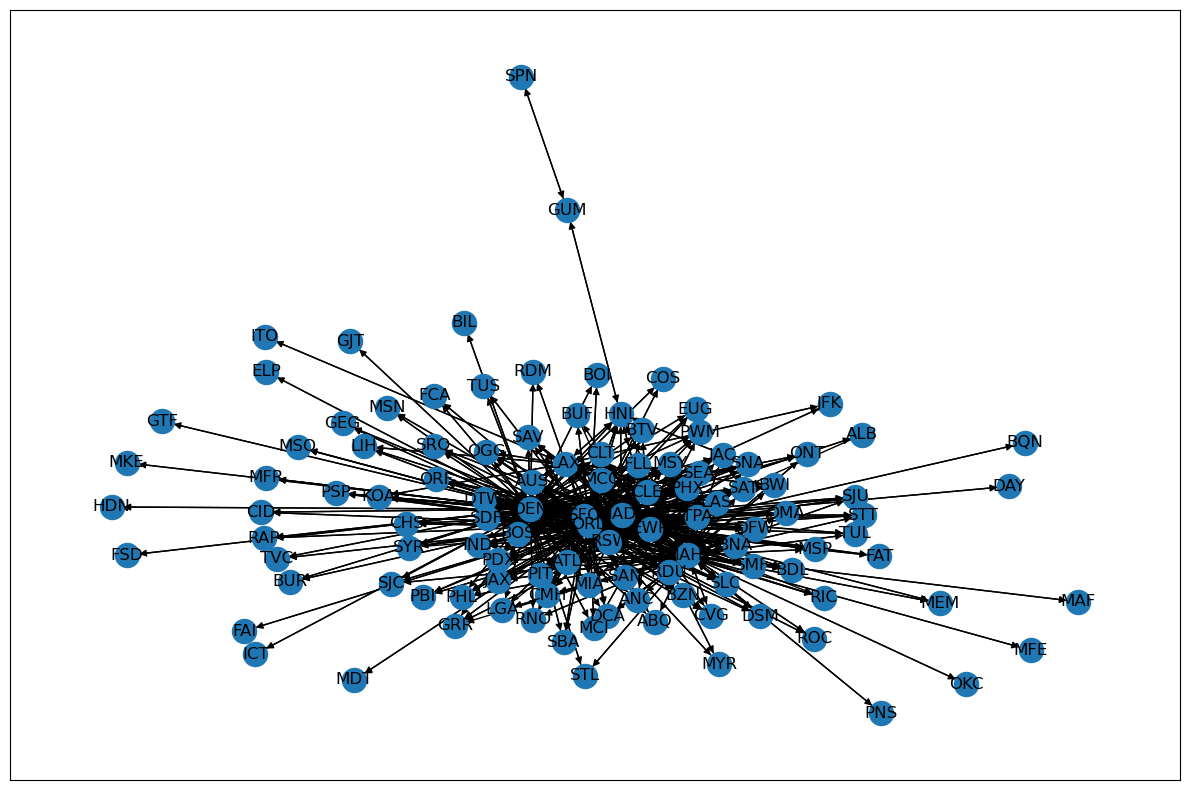

In [17]:
plt.figure(figsize = (12,8))
nx.draw_networkx(AFCN_graph)
plt.tight_layout()
plt.show()

### Degree Distribution

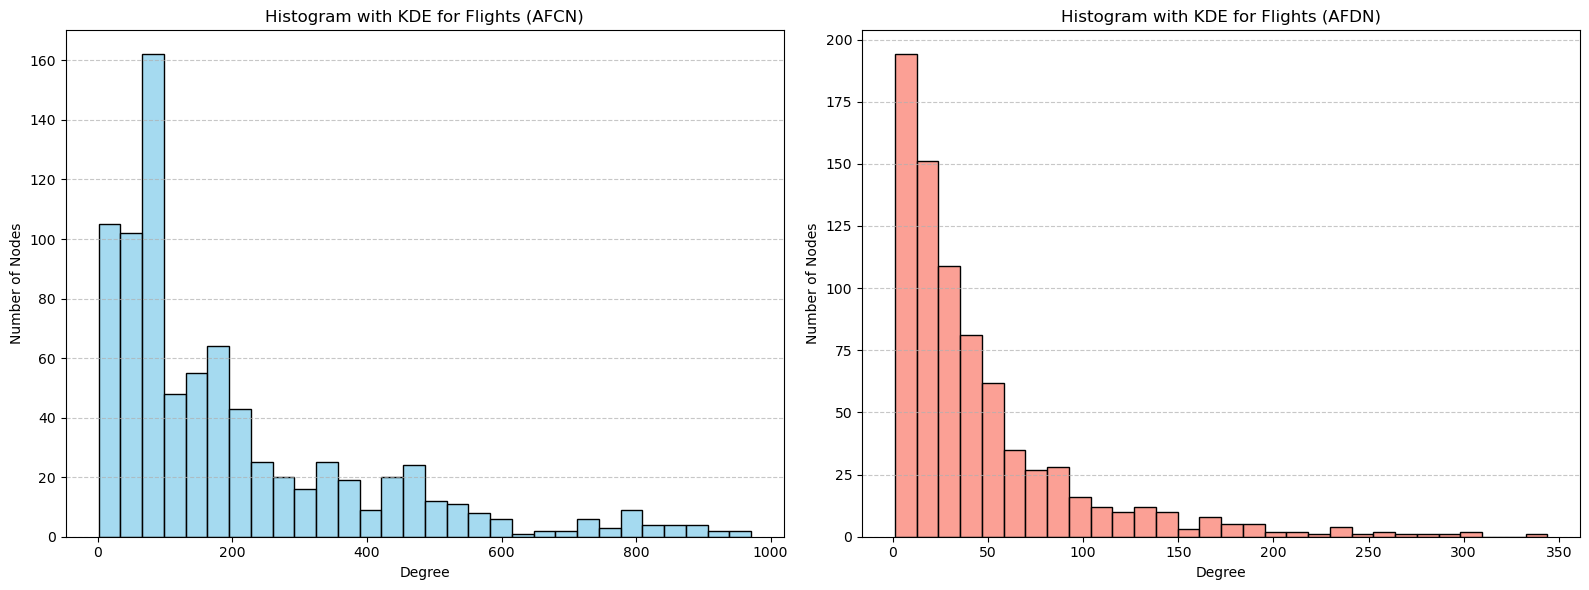

In [18]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first histogram with KDE for df_AFCN
sns.histplot(data=df_AFCN, x='Flights', bins=30, kde=False, color='skyblue', ax=ax1)
ax1.set_title('Histogram with KDE for Flights (AFCN)')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Number of Nodes')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the second histogram with KDE for df_AFDN
sns.histplot(data=df_AFDN, x='Flights', bins=30, kde=False, color='salmon', ax=ax2)
ax2.set_title('Histogram with KDE for Flights (AFDN)')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Number of Nodes')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between subplots
plt.tight_layout()
# Show the subplots

plt.savefig('pdf/degree_distribution.pdf')
plt.show()

### Diameter

In [19]:
# Get the strongly connected components of AFCN_graph
strongly_connected_components_afcn = list(nx.strongly_connected_components(AFCN_graph))

# Find the largest strongly connected component
largest_strongly_connected_component_afcn = max(strongly_connected_components_afcn, key=len)

# Create a subgraph containing only the largest strongly connected component
AFCN_largest_connected_subgraph = AFCN_graph.subgraph(largest_strongly_connected_component_afcn)

# Get the set of nodes in the largest strongly connected component
nodes_in_largest_connected_afcn = set(largest_strongly_connected_component_afcn)

# Find the unconnected nodes
unconnected_nodes_afcn = set(AFCN_graph.nodes) - nodes_in_largest_connected_afcn

# Repeat the same process for AFDN_graph
strongly_connected_components_afdn = list(nx.strongly_connected_components(AFDN_graph))
largest_strongly_connected_component_afdn = max(strongly_connected_components_afdn, key=len)
AFDN_largest_connected_subgraph = AFDN_graph.subgraph(largest_strongly_connected_component_afdn)

# Get the set of nodes in the largest strongly connected component
nodes_in_largest_connected_afdn = set(largest_strongly_connected_component_afdn)

# Find the unconnected nodes
unconnected_nodes_afdn = set(AFDN_graph.nodes) - nodes_in_largest_connected_afdn

# Compute the diameter for the largest connected component subgraphs
afc_diameter = nx.diameter(AFCN_largest_connected_subgraph)
afdn_diameter = nx.diameter(AFDN_largest_connected_subgraph)

AFCN_graph.remove_nodes_from(unconnected_nodes_afcn)
AFDN_graph.remove_nodes_from(unconnected_nodes_afdn)

print("Diameter of AFCN largest connected component:", afc_diameter)
print("Diameter of AFDN largest connected component:", afdn_diameter)

print("Unconnected nodes in AFCN_graph:", unconnected_nodes_afcn)
print("Unconnected nodes in AFDN_graph:", unconnected_nodes_afdn)

Diameter of AFCN largest connected component: 4
Diameter of AFDN largest connected component: 4
Unconnected nodes in AFCN_graph: set()
Unconnected nodes in AFDN_graph: {'HDN', 'DAY'}


### Delay Propagation

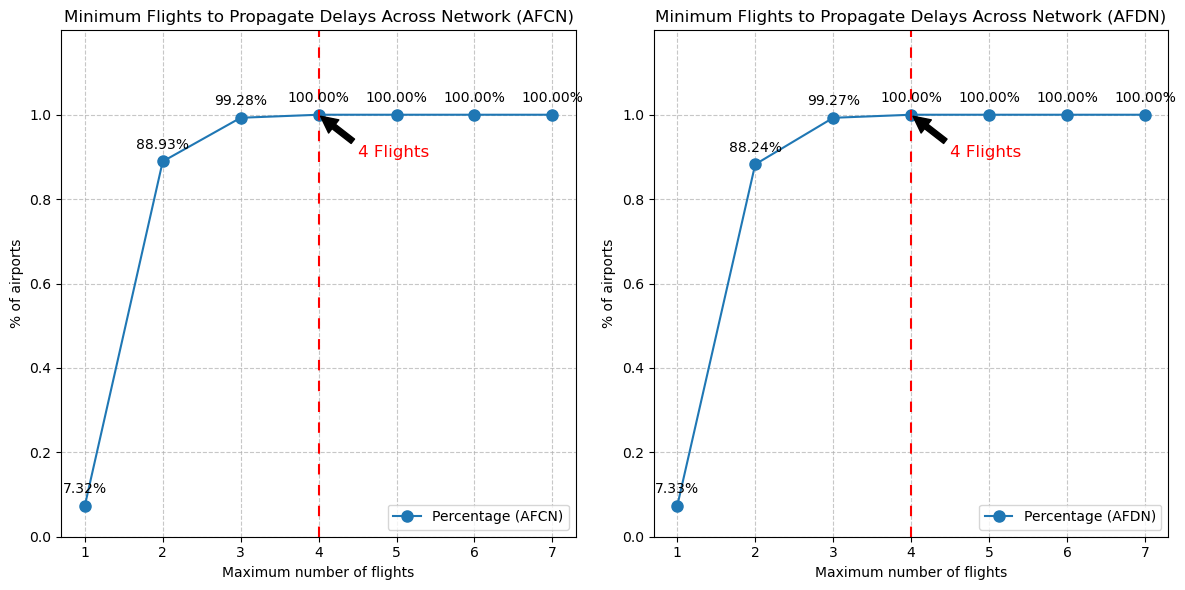

In [20]:
def separation_degrees(shortest_paths, with_n_jumps):
    n = len(shortest_paths)
    coef = []
    for node in shortest_paths:
        shortest_path = shortest_paths[node]
        jumps = np.array(list(shortest_path.values()))
        # Ratio of airports that are reachable with n jumps
        coef.append(np.float(len(jumps[jumps <= with_n_jumps])) / np.float(n - 1))
    return np.mean(coef)

# Assuming you have 'AFCN_graph' and 'AFDN_graph' defined for AFCN and AFDN datasets
shortest_paths_afcn = dict(nx.shortest_path_length(AFCN_graph))
shortest_paths_afdn = dict(nx.shortest_path_length(AFDN_graph))

sample_afcn = []
sample_afdn = []

for i in np.arange(1, 8):  # Adjust the range to go up to 7
    perc_afcn = separation_degrees(shortest_paths_afcn, i)
    perc_afdn = separation_degrees(shortest_paths_afdn, i)
    sample_afcn.append(perc_afcn)
    sample_afdn.append(perc_afdn)

# Clip the values to ensure they are between 0 and 1
sample_afcn = np.clip(sample_afcn, 0, 1)
sample_afdn = np.clip(sample_afdn, 0, 1)

plt.figure(figsize=(12, 6))  # Adjust the figure size for better visibility

# Plot the data points and line for AFCN
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 8), sample_afcn, 'o-', markersize=8, label='Percentage (AFCN)')
plt.xlabel('Maximum number of flights')
plt.ylabel('% of airports')
plt.ylim(0, 1.2)  # Set the y-axis limit to 1.0
plt.xticks(np.arange(1, 8))  # Adjust the x-axis range to go up to 7
plt.yticks(np.arange(0, 1.2, 0.2))  # Improve y-axis ticks to show percentage values
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Minimum Flights to Propagate Delays Across Network (AFCN)')
plt.legend(loc='lower right')

# Adding data labels for AFCN
for a, b in zip(np.arange(1, 8), sample_afcn):
    plt.text(a, b + 0.03, f'{b:.2%}', ha='center')

# Find the index where percentage first hits 100% for AFCN
index_100_afcn = np.argmax(np.array(sample_afcn) >= 1)
x_value_100_afcn = np.arange(1, 8)[index_100_afcn]

# Draw a broken vertical line at x_value_100_afcn
plt.axvline(x_value_100_afcn, linestyle='--', color='red', linewidth=1.5, dashes=(5, 5))

# Annotate the point
plt.annotate(f'{x_value_100_afcn} Flights', xy=(x_value_100_afcn, 1), xytext=(x_value_100_afcn + 0.5, 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='red')

# Plot the data points and line for AFDN
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 8), sample_afdn, 'o-', markersize=8, label='Percentage (AFDN)')
plt.xlabel('Maximum number of flights')
plt.ylabel('% of airports')
plt.ylim(0, 1.2)  # Set the y-axis limit to 1.0
plt.xticks(np.arange(1, 8))  # Adjust the x-axis range to go up to 7
plt.yticks(np.arange(0, 1.2, 0.2))  # Improve y-axis ticks to show percentage values
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Minimum Flights to Propagate Delays Across Network (AFDN)')
plt.legend(loc='lower right')

# Adding data labels for AFDN
for a, b in zip(np.arange(1, 8), sample_afdn):
    plt.text(a, b + 0.03, f'{b:.2%}', ha='center')

# Find the index where percentage first hits 100% for AFDN
index_100_afdn = np.argmax(np.array(sample_afdn) >= 1)
x_value_100_afdn = np.arange(1, 8)[index_100_afdn]

# Draw a broken vertical line at x_value_100_afdn
plt.axvline(x_value_100_afdn, linestyle='--', color='red', linewidth=1.5, dashes=(5, 5))

# Annotate the point for AFDN
plt.annotate(f'{x_value_100_afdn} Flights', xy=(x_value_100_afdn, 1), xytext=(x_value_100_afdn + 0.5, 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='red')

plt.tight_layout()

plt.savefig('pdf/delay_propagation.pdf')
plt.show()

### Clustering Coefficient

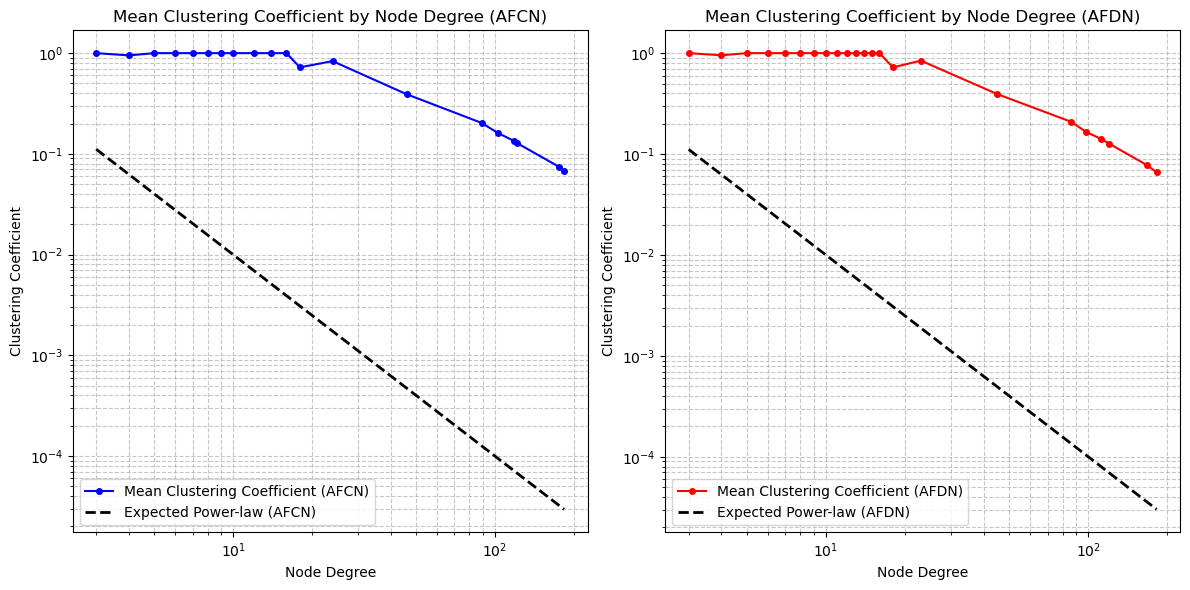

In [21]:
# Calculate clustering coefficients for each node in AFCN_graph and AFDN_graph
cluster_afcn = nx.clustering(AFCN_graph)
cluster_afdn = nx.clustering(AFDN_graph)

# Group by degree and calculate the mean clustering coefficient for AFCN_graph
degree_cluster_afcn = [(degree, cluster_afcn[node]) for node, degree in AFCN_graph.degree()]
df_afcn_cluster = pd.DataFrame(degree_cluster_afcn, columns=['Degree', 'Clustering Coefficient'])
cluster_gr_afcn = df_afcn_cluster.groupby('Degree')['Clustering Coefficient'].mean()

# Group by degree and calculate the mean clustering coefficient for AFDN_graph
degree_cluster_afdn = [(degree, cluster_afdn[node]) for node, degree in AFDN_graph.degree()]
df_afdn_cluster = pd.DataFrame(degree_cluster_afdn, columns=['Degree', 'Clustering Coefficient'])
cluster_gr_afdn = df_afdn_cluster.groupby('Degree')['Clustering Coefficient'].mean()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the data points with markers for AFCN_graph
axes[0].plot(cluster_gr_afcn.index[1:], cluster_gr_afcn.values[1:], 'b.-', markersize=8, label='Mean Clustering Coefficient (AFCN)')

# Plot the expected power-law line for AFCN_graph
axes[0].plot(cluster_gr_afcn.index[1:], cluster_gr_afcn.index[1:]**-2., "k--", label="Expected Power-law (AFCN)", linewidth=2)

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_xlabel('Node Degree')
axes[0].set_ylabel('Clustering Coefficient')
axes[0].set_title('Mean Clustering Coefficient by Node Degree (AFCN)')
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', alpha=0.7)

# Plot the data points with markers for AFDN_graph
axes[1].plot(cluster_gr_afdn.index[1:], cluster_gr_afdn.values[1:], 'r.-', markersize=8, label='Mean Clustering Coefficient (AFDN)')

# Plot the expected power-law line for AFDN_graph
axes[1].plot(cluster_gr_afdn.index[1:], cluster_gr_afdn.index[1:]**-2., "k--", label="Expected Power-law (AFDN)", linewidth=2)

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Node Degree')
axes[1].set_ylabel('Clustering Coefficient')
axes[1].set_title('Mean Clustering Coefficient by Node Degree (AFDN)')
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Out-Degree Centrality

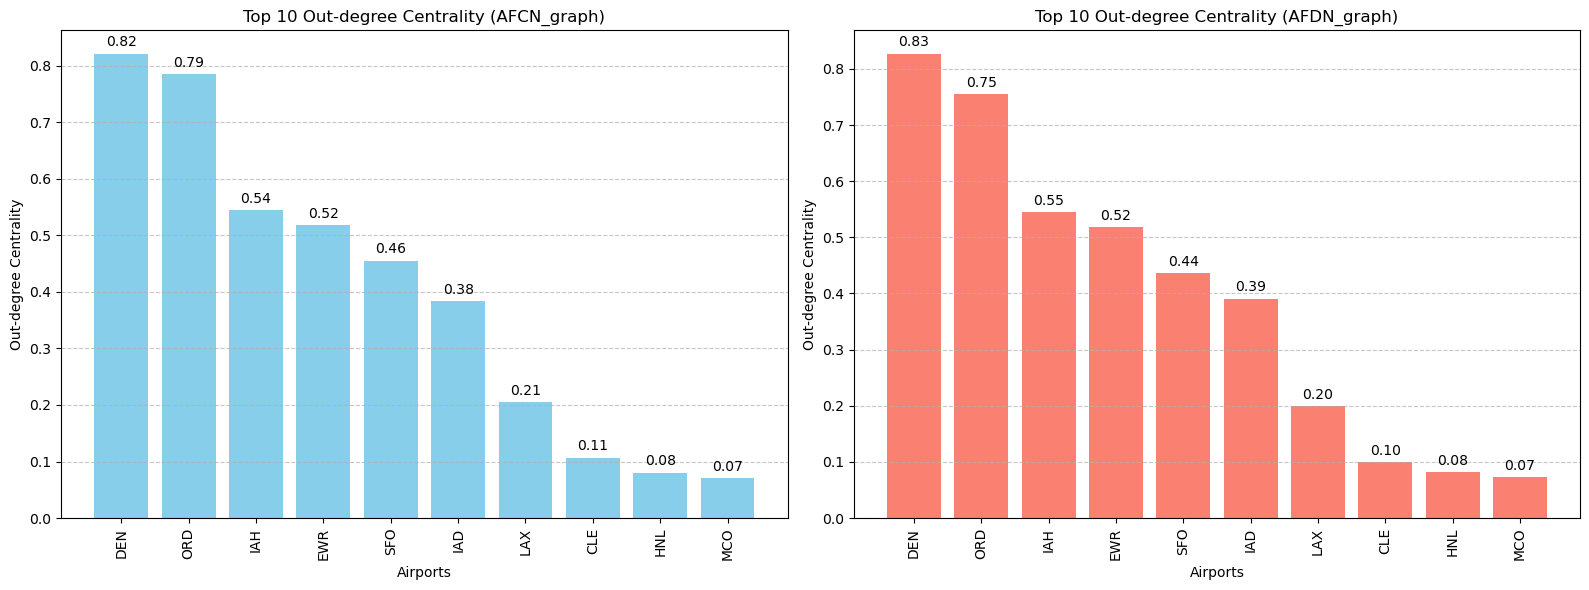

In [22]:
# Calculate out-degree centrality for AFCN_graph
out_degree_centrality_afcn = dict(nx.out_degree_centrality(AFCN_graph))

# Extract airports and corresponding out-degree centrality values for AFCN_graph
airports_afcn = list(out_degree_centrality_afcn.keys())
centrality_values_afcn = list(out_degree_centrality_afcn.values())

# Sort by out-degree centrality values for AFCN_graph
sorted_airports_afcn = [x for _, x in sorted(zip(centrality_values_afcn, airports_afcn), key=lambda pair: pair[0], reverse=True)]
sorted_centrality_values_afcn = sorted(centrality_values_afcn, reverse=True)

# Calculate out-degree centrality for AFDN_graph
out_degree_centrality_afdn = dict(nx.out_degree_centrality(AFDN_graph))

# Extract airports and corresponding out-degree centrality values for AFDN_graph
airports_afdn = list(out_degree_centrality_afdn.keys())
centrality_values_afdn = list(out_degree_centrality_afdn.values())

# Sort by out-degree centrality values for AFDN_graph
sorted_airports_afdn = [x for _, x in sorted(zip(centrality_values_afdn, airports_afdn), key=lambda pair: pair[0], reverse=True)]
sorted_centrality_values_afdn = sorted(centrality_values_afdn, reverse=True)

# Define custom colors for bars
colors_afcn = ['skyblue' for _ in range(10)]  # Light blue
colors_afdn = ['salmon' for _ in range(10)]  # Salmon pink

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for AFCN_graph with custom colors
bars_afcn = axes[0].bar(sorted_airports_afcn[:10], sorted_centrality_values_afcn[:10], color=colors_afcn)
axes[0].set_title('Top 10 Out-degree Centrality (AFCN_graph)')
axes[0].set_xlabel('Airports')
axes[0].set_ylabel('Out-degree Centrality')
axes[0].set_xticklabels(sorted_airports_afcn[:10], rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for AFDN_graph with custom colors
bars_afdn = axes[1].bar(sorted_airports_afdn[:10], sorted_centrality_values_afdn[:10], color=colors_afdn)
axes[1].set_title('Top 10 Out-degree Centrality (AFDN_graph)')
axes[1].set_xlabel('Airports')
axes[1].set_ylabel('Out-degree Centrality')
axes[1].set_xticklabels(sorted_airports_afdn[:10], rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar_afcn, bar_afdn in zip(bars_afcn, bars_afdn):
    height_afcn = bar_afcn.get_height()
    height_afdn = bar_afdn.get_height()
    axes[0].annotate(f'{height_afcn:.2f}', xy=(bar_afcn.get_x() + bar_afcn.get_width() / 2, height_afcn), xytext=(0, 3),
                     textcoords='offset points', ha='center', va='bottom')
    axes[1].annotate(f'{height_afdn:.2f}', xy=(bar_afdn.get_x() + bar_afdn.get_width() / 2, height_afdn), xytext=(0, 3),
                     textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('pdf/airport_degree_centrality.pdf')
plt.show()

In [23]:
# Convert the lists to sets and find the common elements
common_airports_odc = set(sorted_airports_afcn[:10]).intersection(sorted_airports_afdn[:10])
list_airports_odc = list(sorted_airports_afdn[:10])


common_airports_odc

{'CLE', 'DEN', 'EWR', 'HNL', 'IAD', 'IAH', 'LAX', 'MCO', 'ORD', 'SFO'}

### Betweenness Centrality

#### Disruptive Airports

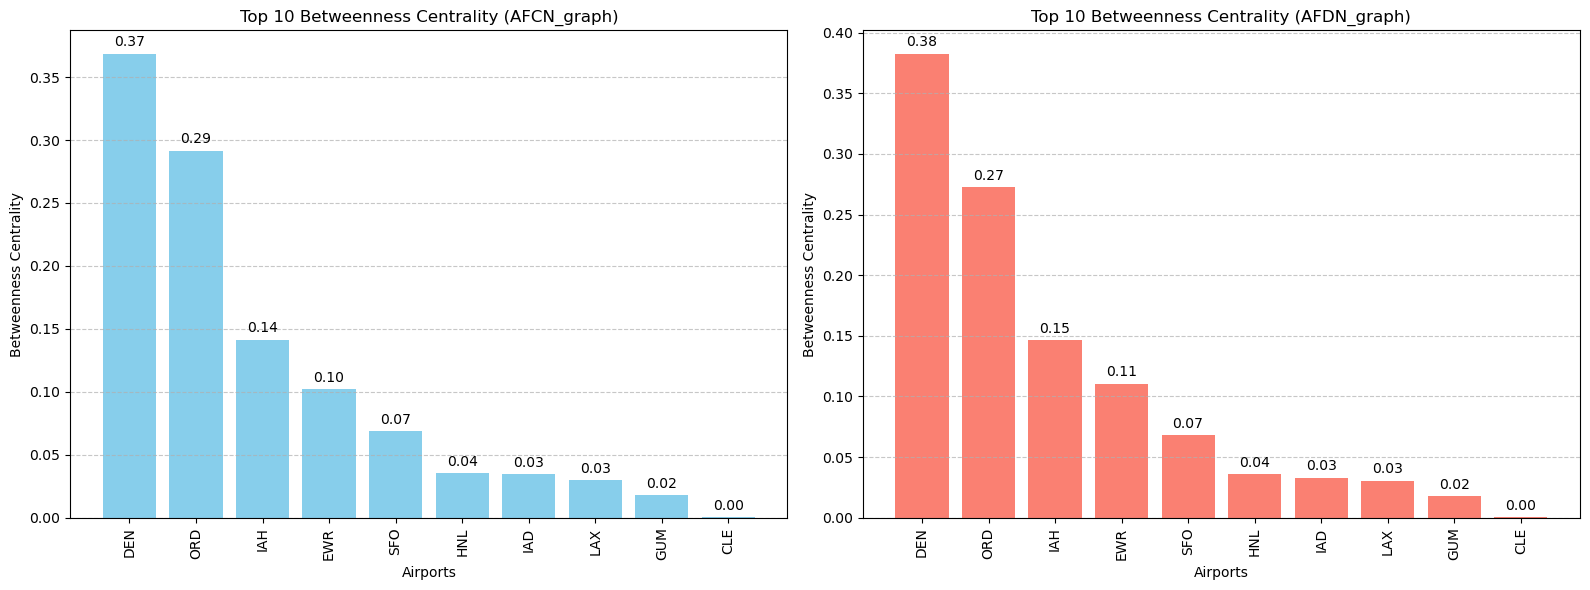

In [24]:
# Calculate betweenness centrality for AFCN_graph
betweenness_centrality_afcn = dict(nx.betweenness_centrality(AFCN_graph))

# Extract airports and corresponding betweenness centrality values for AFCN_graph
airports_afcn = list(betweenness_centrality_afcn.keys())
centrality_values_afcn = list(betweenness_centrality_afcn.values())

# Sort by betweenness centrality values for AFCN_graph
sorted_airports_afcn = [x for _, x in sorted(zip(centrality_values_afcn, airports_afcn), key=lambda pair: pair[0], reverse=True)]
sorted_centrality_values_afcn = sorted(centrality_values_afcn, reverse=True)

# Calculate betweenness centrality for AFDN_graph
betweenness_centrality_afdn = dict(nx.betweenness_centrality(AFDN_graph))

# Extract airports and corresponding betweenness centrality values for AFDN_graph
airports_afdn = list(betweenness_centrality_afdn.keys())
centrality_values_afdn = list(betweenness_centrality_afdn.values())

# Sort by betweenness centrality values for AFDN_graph
sorted_airports_afdn = [x for _, x in sorted(zip(centrality_values_afdn, airports_afdn), key=lambda pair: pair[0], reverse=True)]
sorted_centrality_values_afdn = sorted(centrality_values_afdn, reverse=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for AFCN_graph with custom colors
bars_afcn = axes[0].bar(sorted_airports_afcn[:10], sorted_centrality_values_afcn[:10], color=colors_afcn)
axes[0].set_title('Top 10 Betweenness Centrality (AFCN_graph)')
axes[0].set_xlabel('Airports')
axes[0].set_ylabel('Betweenness Centrality')
axes[0].set_xticklabels(sorted_airports_afcn[:10], rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for AFDN_graph with custom colors
bars_afdn = axes[1].bar(sorted_airports_afdn[:10], sorted_centrality_values_afdn[:10], color=colors_afdn)
axes[1].set_title('Top 10 Betweenness Centrality (AFDN_graph)')
axes[1].set_xlabel('Airports')
axes[1].set_ylabel('Betweenness Centrality')
axes[1].set_xticklabels(sorted_airports_afdn[:10], rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar_afcn, bar_afdn in zip(bars_afcn, bars_afdn):
    height_afcn = bar_afcn.get_height()
    height_afdn = bar_afdn.get_height()
    axes[0].annotate(f'{height_afcn:.2f}', xy=(bar_afcn.get_x() + bar_afcn.get_width() / 2, height_afcn), xytext=(0, 3),
                     textcoords='offset points', ha='center', va='bottom')
    axes[1].annotate(f'{height_afdn:.2f}', xy=(bar_afdn.get_x() + bar_afdn.get_width() / 2, height_afdn), xytext=(0, 3),
                     textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('pdf/airport_betweenness_centrality.pdf')
plt.show()

In [25]:
# Convert the lists to sets and find the common elements
common_airports_bc = set(sorted_airports_afcn[:10]).intersection(sorted_airports_afdn[:10])
list_airports_bc = list(sorted_airports_afdn[:10])
common_airports_bc

{'CLE', 'DEN', 'EWR', 'GUM', 'HNL', 'IAD', 'IAH', 'LAX', 'ORD', 'SFO'}

#### Disruptive Airport-Pairs

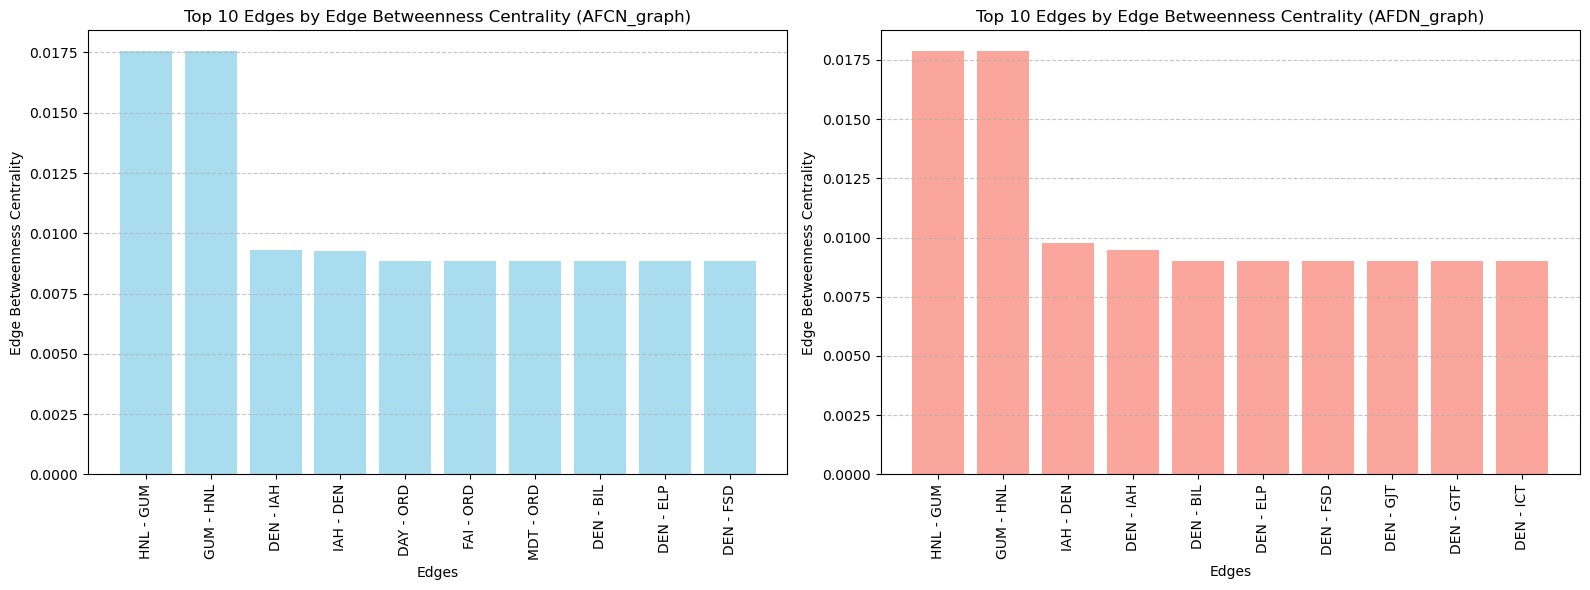

In [26]:
# Extract the top 10 edges and their edge betweenness centrality values for AFCN_graph
top_edges_afcn = sorted(nx.edge_betweenness_centrality(AFCN_graph).items(), key=lambda x: x[1], reverse=True)[:10]
edges_afcn = [f"{src} - {dest}" for (src, dest), _ in top_edges_afcn]
edge_betweenness_values_afcn = [value for _, value in top_edges_afcn]

# Extract the top 10 edges and their edge betweenness centrality values for AFDN_graph
top_edges_afdn = sorted(nx.edge_betweenness_centrality(AFDN_graph).items(), key=lambda x: x[1], reverse=True)[:10]
edges_afdn = [f"{src} - {dest}" for (src, dest), _ in top_edges_afdn]
edge_betweenness_values_afdn = [value for _, value in top_edges_afdn]

# Create a figure with subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the top 10 edges by edge betweenness centrality for AFCN_graph
axes[0].bar(edges_afcn, edge_betweenness_values_afcn, color='skyblue', alpha=0.7)
axes[0].set_xlabel('Edges')
axes[0].set_ylabel('Edge Betweenness Centrality')
axes[0].set_title('Top 10 Edges by Edge Betweenness Centrality (AFCN_graph)')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the top 10 edges by edge betweenness centrality for AFDN_graph
axes[1].bar(edges_afdn, edge_betweenness_values_afdn, color='salmon', alpha=0.7)
axes[1].set_xlabel('Edges')
axes[1].set_ylabel('Edge Betweenness Centrality')
axes[1].set_title('Top 10 Edges by Edge Betweenness Centrality (AFDN_graph)')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('pdf/airport_edge_centrality.pdf')

# Show the subplots
plt.show()

In [27]:
# Convert the lists to sets and find the common elements
common_edges = set(edges_afcn).intersection(edges_afdn)

# Convert the result back to a list if needed
common_edges_list = list(common_edges)

# Print the common elements
common_edges_list

['HNL - GUM',
 'DEN - IAH',
 'GUM - HNL',
 'DEN - ELP',
 'DEN - BIL',
 'IAH - DEN',
 'DEN - FSD']

### Percolation

#### Betweenness Centrality

In [28]:
# Define a function to perform the node removal and record betweenness centrality
def calculate_betweenness_centrality(graph, num_iterations):
    # Create an empty dataframe to store removed nodes and their betweenness centrality values
    removed_nodes_df = pd.DataFrame(columns=["Removed_Node", "Betweenness_Centrality"])

    # Create a copy of the original graph for each iteration
    temp_graph = graph.copy()

    for iteration in range(num_iterations):
        # Calculate betweenness centrality for the current graph
        betweenness_centrality = nx.betweenness_centrality(temp_graph)

        # Find the node with the highest betweenness centrality
        removed_node = max(betweenness_centrality, key=betweenness_centrality.get)

        # Remove the node with the highest betweenness centrality
        temp_graph.remove_node(removed_node)

        # Store the removed node and its corresponding betweenness centrality in the dataframe
        removed_nodes_df = pd.concat([removed_nodes_df, pd.DataFrame({"Removed_Node": [removed_node],
                                                                     "Betweenness_Centrality": [betweenness_centrality[removed_node]]})],
                                     ignore_index=True)

    return removed_nodes_df

# Define the number of iterations
num_iterations = 10

# Call the function for AFCN_graph and display the final dataframe
removed_nodes_df_afcn = calculate_betweenness_centrality(AFCN_graph, num_iterations)
print("AFCN Betweenness Centrality:")
print(removed_nodes_df_afcn)

# Call the function for AFDN_graph and display the final dataframe
removed_nodes_df_afdn = calculate_betweenness_centrality(AFDN_graph, num_iterations)
print("\nAFDN Betweenness Centrality:")
print(removed_nodes_df_afdn)

AFCN Betweenness Centrality:
  Removed_Node  Betweenness_Centrality
0          DEN                0.368703
1          ORD                0.429137
2          IAH                0.223741
3          EWR                0.232138
4          SFO                0.210309
5          IAD                0.171751
6          LAX                0.034501
7          CLE                0.001832
8          HNL                0.000373
9          ABQ                0.000000

AFDN Betweenness Centrality:
  Removed_Node  Betweenness_Centrality
0          DEN                0.382822
1          ORD                0.422835
2          IAH                0.235547
3          EWR                0.223231
4          SFO                0.198540
5          IAD                0.166850
6          LAX                0.034307
7          CLE                0.001523
8          HNL                0.000388
9          ABQ                0.000000


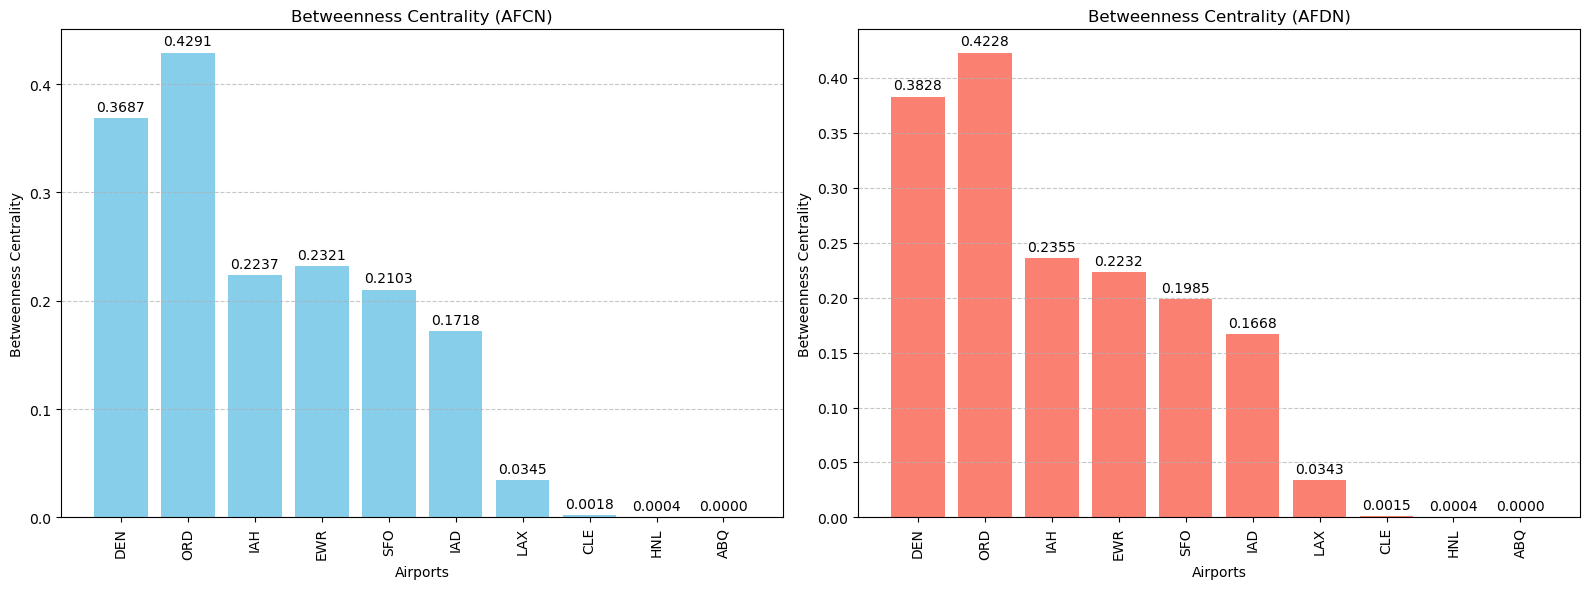

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Data for removed_nodes_df_afcn and removed_nodes_df_afdn
airports_afcn = removed_nodes_df_afcn['Removed_Node']
centrality_values_afcn = removed_nodes_df_afcn['Betweenness_Centrality']

airports_afdn = removed_nodes_df_afdn['Removed_Node']
centrality_values_afdn = removed_nodes_df_afdn['Betweenness_Centrality']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for removed_nodes_df_afcn
bars_afcn = axes[0].bar(airports_afcn, centrality_values_afcn, color='skyblue')
axes[0].set_title('Betweenness Centrality (AFCN)')
axes[0].set_xlabel('Airports')
axes[0].set_ylabel('Betweenness Centrality')
axes[0].set_xticklabels(airports_afcn, rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for removed_nodes_df_afdn
bars_afdn = axes[1].bar(airports_afdn, centrality_values_afdn, color='salmon')
axes[1].set_title('Betweenness Centrality (AFDN)')
axes[1].set_xlabel('Airports')
axes[1].set_ylabel('Betweenness Centrality')
axes[1].set_xticklabels(airports_afdn, rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar_afcn, bar_afdn in zip(bars_afcn, bars_afdn):
    height_afcn = bar_afcn.get_height()
    height_afdn = bar_afdn.get_height()
    axes[0].annotate(f'{height_afcn:.4f}', xy=(bar_afcn.get_x() + bar_afcn.get_width() / 2, height_afcn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    axes[1].annotate(f'{height_afdn:.4f}', xy=(bar_afdn.get_x() + bar_afdn.get_width() / 2, height_afdn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('pdf/airport_percolation.pdf')
plt.show()

In [30]:
common_removed_nodes_bcp = set(removed_nodes_df_afcn['Removed_Node']).intersection(removed_nodes_df_afdn['Removed_Node'])
list_airport_bcp = removed_nodes_df_afdn['Removed_Node'].tolist()
common_removed_nodes_bcp

{'ABQ', 'CLE', 'DEN', 'EWR', 'HNL', 'IAD', 'IAH', 'LAX', 'ORD', 'SFO'}

## Reconciliation

In [31]:
print(common_airports_odc)
print(common_airports_bc)
print(common_removed_nodes_bcp)

{'MCO', 'DEN', 'IAH', 'CLE', 'IAD', 'ORD', 'HNL', 'EWR', 'LAX', 'SFO'}
{'DEN', 'IAH', 'CLE', 'IAD', 'ORD', 'HNL', 'GUM', 'EWR', 'LAX', 'SFO'}
{'ABQ', 'DEN', 'IAH', 'CLE', 'IAD', 'ORD', 'HNL', 'EWR', 'LAX', 'SFO'}


## Flight Connection Network (FCN)

### Graph Creation

In [32]:
FCCN_graph = nx.from_pandas_edgelist(df_FCCN,
                                source='src_flight',
                                target='target_flight',
                                edge_attr='frequency',
                                create_using = nx.DiGraph())

In [33]:
FCDN_graph = nx.from_pandas_edgelist(df_FCDN,
                                source='src_flight',
                                target='target_flight',
                                edge_attr='frequency',
                                create_using = nx.DiGraph())

### Drawing the Network

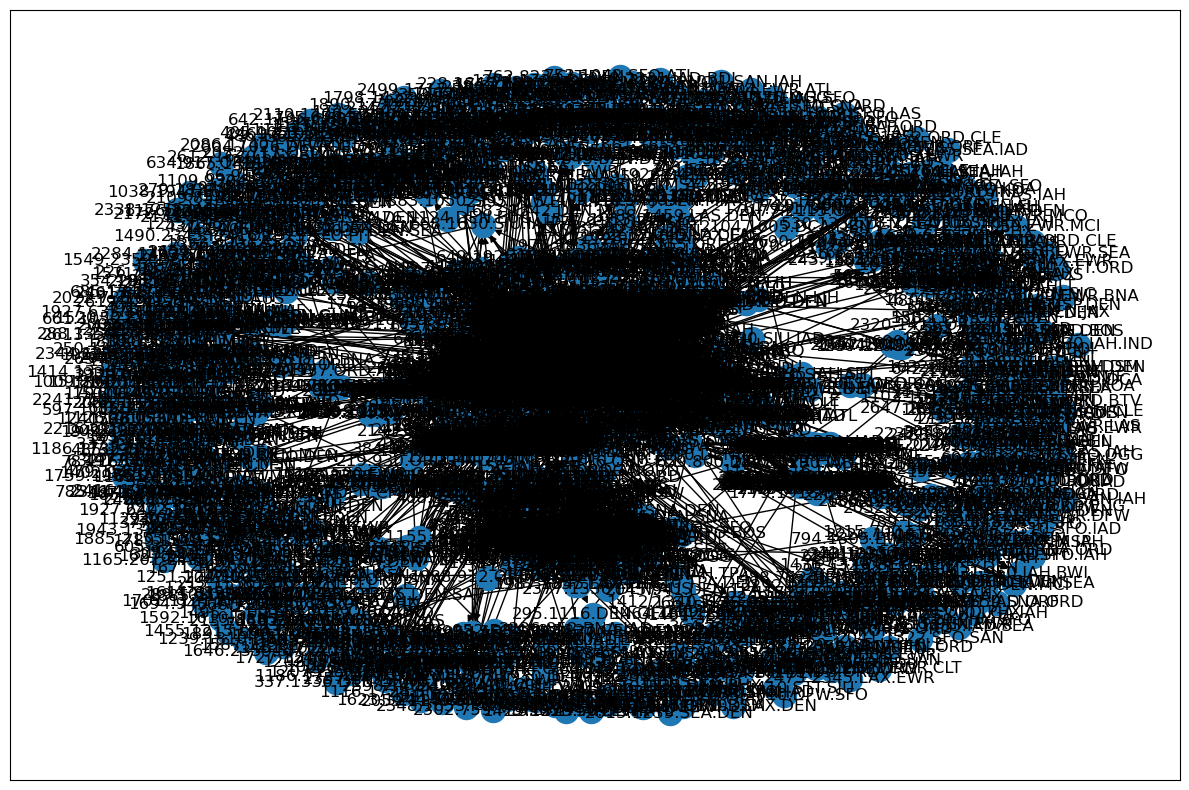

In [34]:
plt.figure(figsize = (12,8))
nx.draw_networkx(FCCN_graph)
plt.tight_layout()
plt.show()

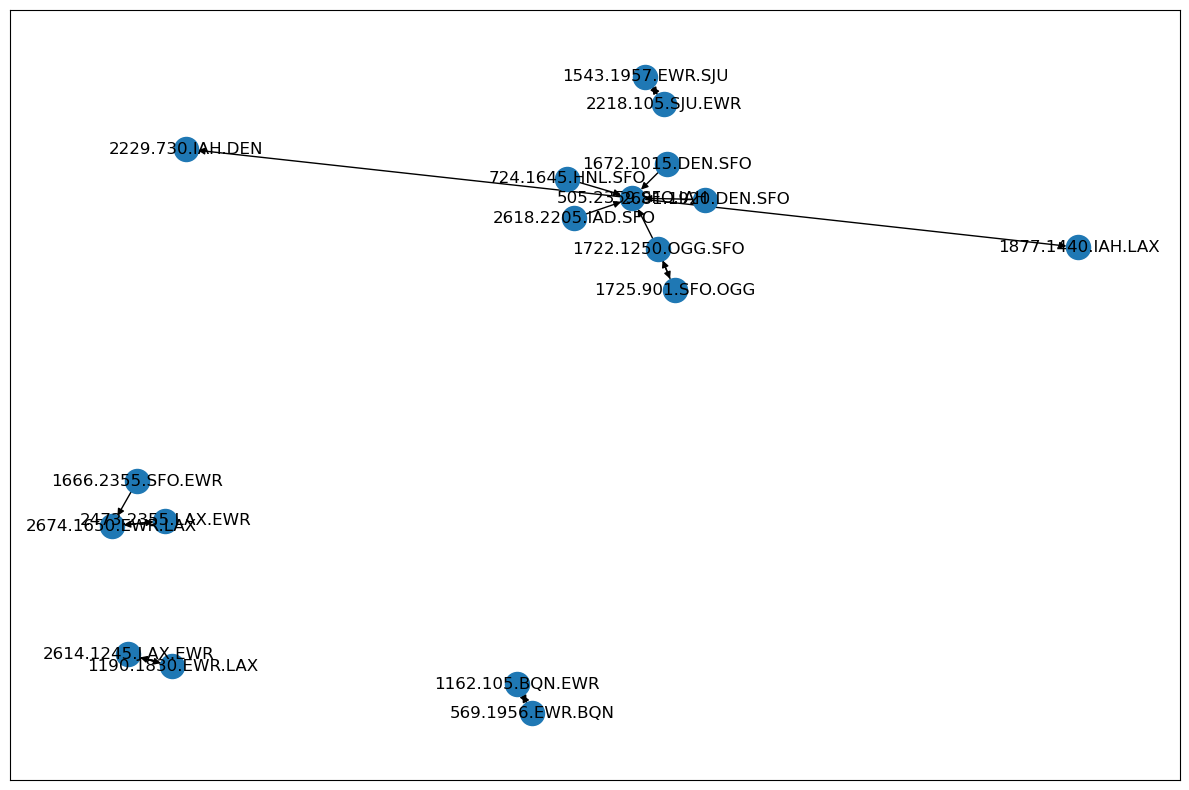

In [35]:
plt.figure(figsize = (12,8))
nx.draw_networkx(FCDN_graph)
plt.tight_layout()
plt.show()

### Degree Distribution

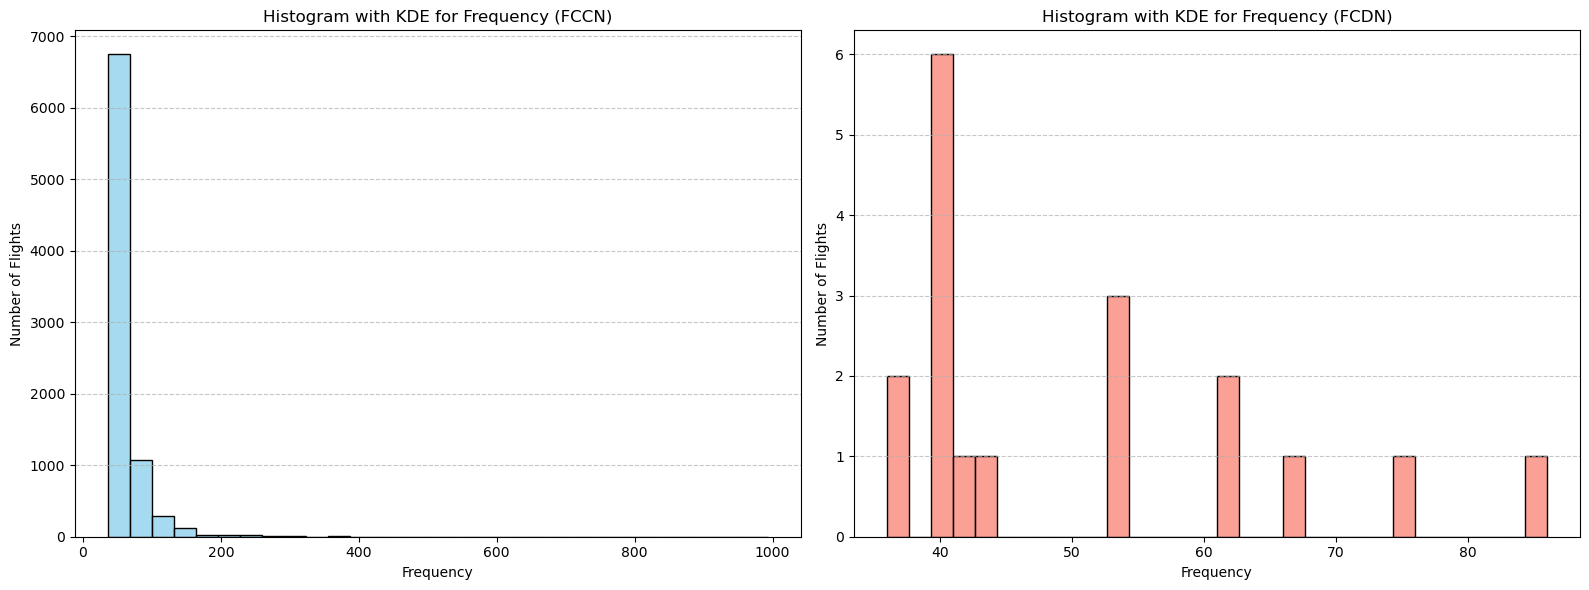

In [36]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first histogram with KDE for FCCN
sns.histplot(data=df_FCCN, x='frequency', bins=30, kde=False, color='skyblue', ax=ax1)
ax1.set_title('Histogram with KDE for Frequency (FCCN)')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Number of Flights')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the second histogram with KDE for FCDN
sns.histplot(data=df_FCDN, x='frequency', bins=30, kde=False, color='salmon', ax=ax2)
ax2.set_title('Histogram with KDE for Frequency (FCDN)')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Number of Flights')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

### Diameter

In [37]:
# Compute the diameter of FCCN_graph
try:
    diameter_fccn = nx.diameter(FCCN_graph)
except nx.NetworkXError:
    diameter_fccn = "infinite"

# Compute the diameter of FCDN_graph
try:
    diameter_fcdn = nx.diameter(FCDN_graph)
except nx.NetworkXError:
    diameter_fcdn = "infinite"

print("Diameter of FCCN_graph:", diameter_fccn)
print("Diameter of FCDN_graph:", diameter_fcdn)

Diameter of FCCN_graph: infinite
Diameter of FCDN_graph: infinite


### Delay Propagation

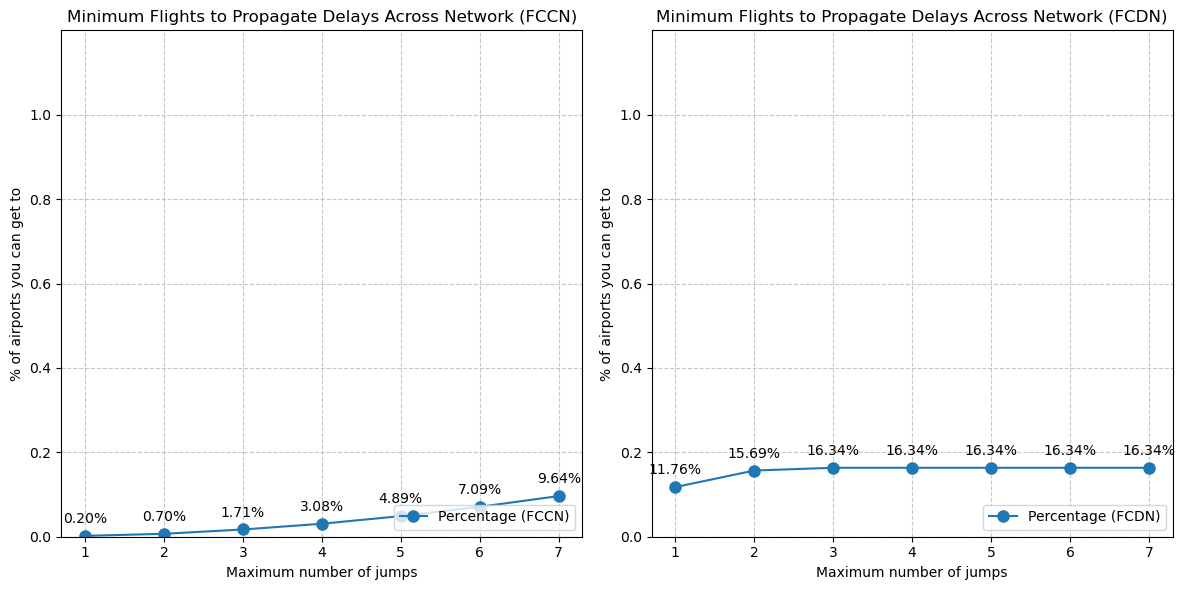

In [38]:
# Assuming you have 'FCCN_graph' and 'FCDN_graph' defined for FCCN and FCDN datasets
shortest_paths_fccn = dict(nx.shortest_path_length(FCCN_graph))
shortest_paths_fcdn = dict(nx.shortest_path_length(FCDN_graph))

sample_fccn = []
sample_fcdn = []

for i in np.arange(1, 8):  # Adjust the range to go up to 7
    perc_fccn = separation_degrees(shortest_paths_fccn, i)
    perc_fcdn = separation_degrees(shortest_paths_fcdn, i)
    sample_fccn.append(perc_fccn)
    sample_fcdn.append(perc_fcdn)

# Clip the values to ensure they are between 0 and 1
sample_fccn = np.clip(sample_fccn, 0, 1)
sample_fcdn = np.clip(sample_fcdn, 0, 1)

plt.figure(figsize=(12, 6))  # Adjust the figure size for better visibility

# Plot the data points and line for FCCN
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 8), sample_fccn, 'o-', markersize=8, label='Percentage (FCCN)')
plt.xlabel('Maximum number of jumps')
plt.ylabel('% of airports you can get to')
plt.ylim(0, 1.2)  # Set the y-axis limit to 1.0
plt.xticks(np.arange(1, 8))  # Adjust the x-axis range to go up to 7
plt.yticks(np.arange(0, 1.2, 0.2))  # Improve y-axis ticks to show percentage values
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Minimum Flights to Propagate Delays Across Network (FCCN)')
plt.legend(loc='lower right')

# Adding data labels for FCCN
for a, b in zip(np.arange(1, 8), sample_fccn):
    plt.text(a, b + 0.03, f'{b:.2%}', ha='center')

# Find the index where percentage first hits 100% for FCCN
index_100_fccn = np.argmax(np.array(sample_fccn) >= 1)
x_value_100_fccn = np.arange(1, 8)[index_100_fccn]

# # Draw a broken vertical line at x_value_100_fccn
# plt.axvline(x_value_100_fccn, linestyle='--', color='red', linewidth=1.5, dashes=(5, 5))

# # Annotate the point for FCCN
# plt.annotate(f'{x_value_100_fccn} Jumps', xy=(x_value_100_fccn, 1), xytext=(x_value_100_fccn + 0.5, 0.9),
#              arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='red')

# Plot the data points and line for FCDN
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 8), sample_fcdn, 'o-', markersize=8, label='Percentage (FCDN)')
plt.xlabel('Maximum number of jumps')
plt.ylabel('% of airports you can get to')
plt.ylim(0, 1.2)  # Set the y-axis limit to 1.0
plt.xticks(np.arange(1, 8))  # Adjust the x-axis range to go up to 7
plt.yticks(np.arange(0, 1.2, 0.2))  # Improve y-axis ticks to show percentage values
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Minimum Flights to Propagate Delays Across Network (FCDN)')
plt.legend(loc='lower right')

# Adding data labels for FCDN
for a, b in zip(np.arange(1, 8), sample_fcdn):
    plt.text(a, b + 0.03, f'{b:.2%}', ha='center')

# Find the index where percentage first hits 100% for FCDN
index_100_fcdn = np.argmax(np.array(sample_fcdn) >= 1)
x_value_100_fcdn = np.arange(1, 8)[index_100_fcdn]

# # Draw a broken vertical line at x_value_100_fcdn
# plt.axvline(x_value_100_fcdn, linestyle='--', color='red', linewidth=1.5, dashes=(5, 5))

# # Annotate the point for FCDN
# plt.annotate(f'{x_value_100_fcdn} Jumps', xy=(x_value_100_fcdn, 1), xytext=(x_value_100_fcdn + 0.5, 0.9),
#              arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='red')

plt.tight_layout()
plt.show()

### Clustering Coefficient

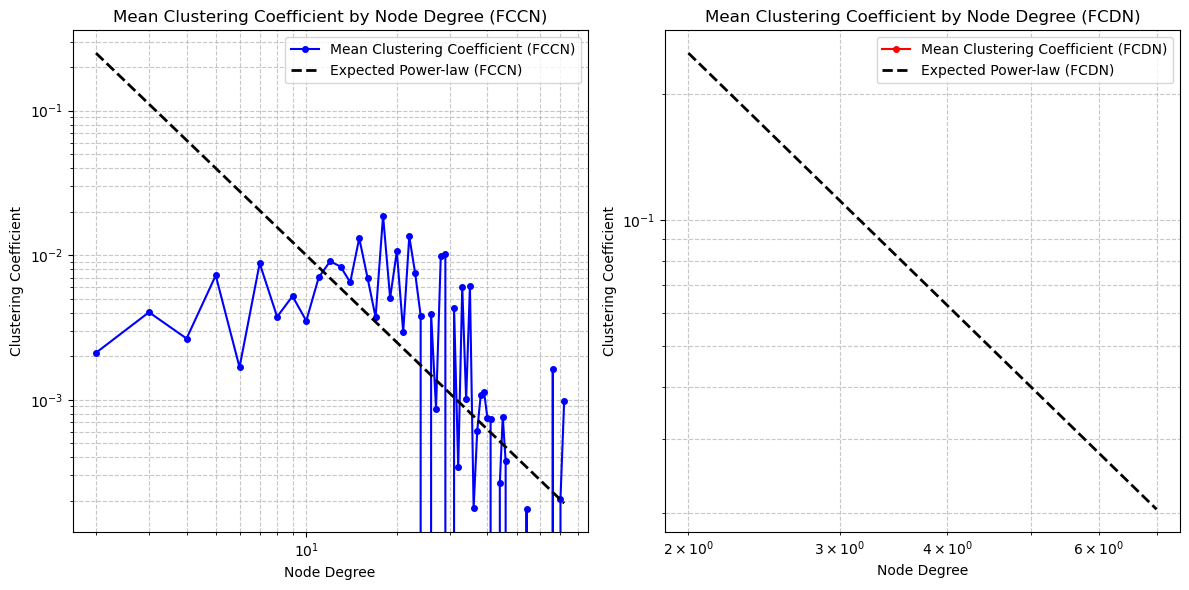

In [39]:
# Calculate clustering coefficients for each node in FCCN_graph and FCDN_graph
cluster_fccn = nx.clustering(FCCN_graph)
cluster_fcdn = nx.clustering(FCDN_graph)

# Filter out nodes with zero degree for FCCN_graph
degree_cluster_fccn = [(degree, cluster_fccn[node]) for node, degree in FCCN_graph.degree() if degree > 0]
df_fccn_cluster = pd.DataFrame(degree_cluster_fccn, columns=['Degree', 'Clustering Coefficient'])
cluster_gr_fccn = df_fccn_cluster.groupby('Degree')['Clustering Coefficient'].mean()

# Filter out nodes with zero degree for FCDN_graph
degree_cluster_fcdn = [(degree, cluster_fcdn[node]) for node, degree in FCDN_graph.degree() if degree > 0]
df_fcdn_cluster = pd.DataFrame(degree_cluster_fcdn, columns=['Degree', 'Clustering Coefficient'])
cluster_gr_fcdn = df_fcdn_cluster.groupby('Degree')['Clustering Coefficient'].mean()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the data points with markers for FCCN_graph
axes[0].plot(cluster_gr_fccn.index[1:], cluster_gr_fccn.values[1:], 'b.-', markersize=8, label='Mean Clustering Coefficient (FCCN)')

# Plot the expected power-law line for FCCN_graph
axes[0].plot(cluster_gr_fccn.index[1:], cluster_gr_fccn.index[1:]**-2., "k--", label="Expected Power-law (FCCN)", linewidth=2)

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_xlabel('Node Degree')
axes[0].set_ylabel('Clustering Coefficient')
axes[0].set_title('Mean Clustering Coefficient by Node Degree (FCCN)')
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', alpha=0.7)

# Plot the data points with markers for FCDN_graph
axes[1].plot(cluster_gr_fcdn.index[1:], cluster_gr_fcdn.values[1:], 'r.-', markersize=8, label='Mean Clustering Coefficient (FCDN)')

# Plot the expected power-law line for FCDN_graph
axes[1].plot(cluster_gr_fcdn.index[1:], cluster_gr_fcdn.index[1:]**-2., "k--", label="Expected Power-law (FCDN)", linewidth=2)

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Node Degree')
axes[1].set_ylabel('Clustering Coefficient')
axes[1].set_title('Mean Clustering Coefficient by Node Degree (FCDN)')
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Out-Degree Centrality

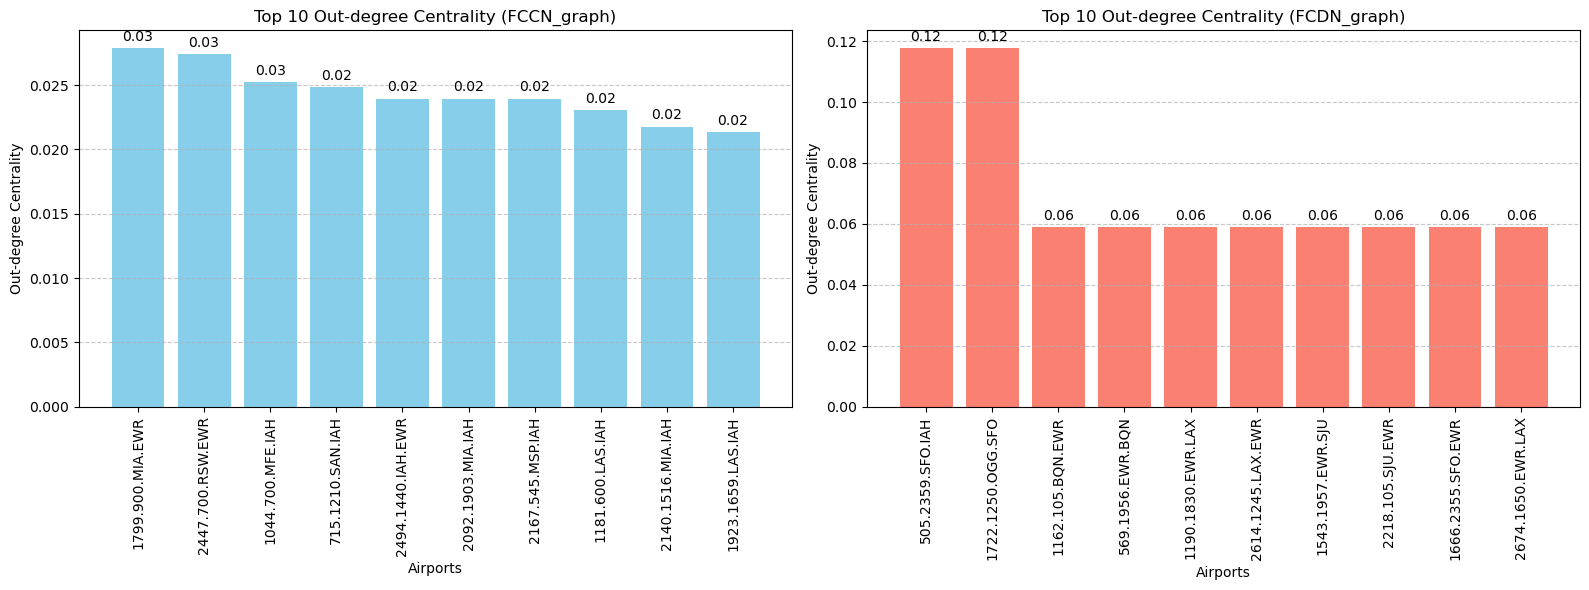

In [40]:
# Calculate out-degree centrality for FCCN_graph
out_degree_centrality_fccn = dict(nx.out_degree_centrality(FCCN_graph))
sorted_out_degree_fccn = sorted(out_degree_centrality_fccn.items(), key=lambda x: x[1], reverse=True)

# Calculate out-degree centrality for FCDN_graph
out_degree_centrality_fcdn = dict(nx.out_degree_centrality(FCDN_graph))
sorted_out_degree_fcdn = sorted(out_degree_centrality_fcdn.items(), key=lambda x: x[1], reverse=True)

# Extract airports and corresponding out-degree centrality values for FCCN and FCDN
airports_fccn, centrality_values_fccn = zip(*sorted_out_degree_fccn)
airports_fcdn, centrality_values_fcdn = zip(*sorted_out_degree_fcdn)

# Define custom colors for bars
colors_fccn = ['skyblue' for _ in range(10)]  # Light blue
colors_fcdn = ['salmon' for _ in range(10)]  # Salmon pink

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for FCCN_graph with custom colors
bars_fccn = axes[0].bar(airports_fccn[:10], centrality_values_fccn[:10], color=colors_fccn)
axes[0].set_title('Top 10 Out-degree Centrality (FCCN_graph)')
axes[0].set_xlabel('Airports')
axes[0].set_ylabel('Out-degree Centrality')
axes[0].set_xticklabels(airports_fccn[:10], rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for FCDN_graph with custom colors
bars_fcdn = axes[1].bar(airports_fcdn[:10], centrality_values_fcdn[:10], color=colors_fcdn)
axes[1].set_title('Top 10 Out-degree Centrality (FCDN_graph)')
axes[1].set_xlabel('Airports')
axes[1].set_ylabel('Out-degree Centrality')
axes[1].set_xticklabels(airports_fcdn[:10], rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar_fccn, bar_fcdn in zip(bars_fccn, bars_fcdn):
    height_fccn = bar_fccn.get_height()
    height_fcdn = bar_fcdn.get_height()
    axes[0].annotate(f'{height_fccn:.2f}', xy=(bar_fccn.get_x() + bar_fccn.get_width() / 2, height_fccn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    axes[1].annotate(f'{height_fcdn:.2f}', xy=(bar_fcdn.get_x() + bar_fcdn.get_width() / 2, height_fcdn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('pdf/flight_degree_centrality.pdf')
plt.show()

In [41]:
# Convert the lists to sets and find the common elements
common_flights_odc = set(airports_fccn[10]).intersection(airports_fcdn[:10])
list_odc = list(airports_fcdn[:10])
list_odp = list(airports_fccn[:10])
common_flights_odc

set()

### Betweenness Centrality

#### Distruptive Flights

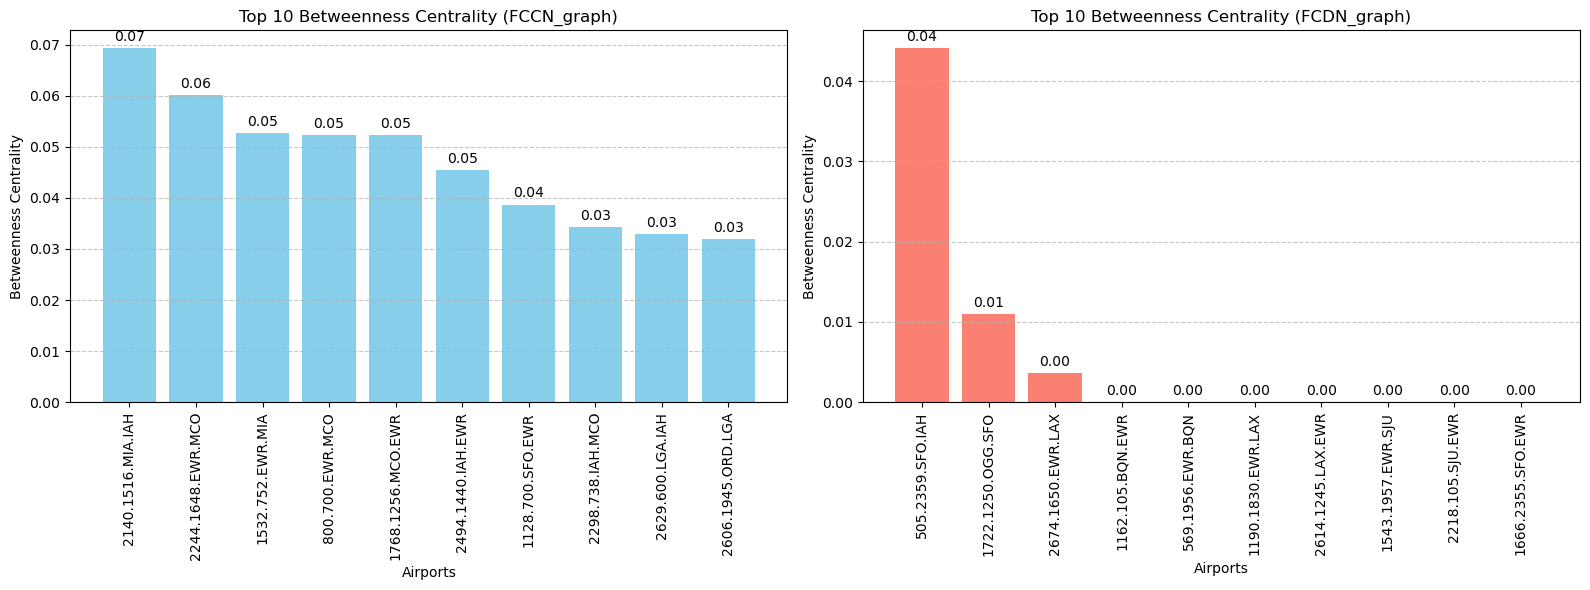

In [42]:
# Calculate betweenness centrality for FCCN_graph
betweenness_centrality_fccn = dict(nx.betweenness_centrality(FCCN_graph))

# Calculate betweenness centrality for FCDN_graph
betweenness_centrality_fcdn = dict(nx.betweenness_centrality(FCDN_graph))

# Sort by betweenness centrality values for FCCN_graph
sorted_airports_fccn = sorted(betweenness_centrality_fccn.items(), key=lambda x: x[1], reverse=True)

# Sort by betweenness centrality values for FCDN_graph
sorted_airports_fcdn = sorted(betweenness_centrality_fcdn.items(), key=lambda x: x[1], reverse=True)

# Extract airports and corresponding betweenness centrality values for FCCN and FCDN
airports_fccn, centrality_values_fccn = zip(*sorted_airports_fccn)
airports_fcdn, centrality_values_fcdn = zip(*sorted_airports_fcdn)

# Define custom colors for bars
colors_fccn = ['skyblue' for _ in range(10)]  # Light blue
colors_fcdn = ['salmon' for _ in range(10)]  # Salmon pink

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for FCCN_graph with custom colors
bars_fccn = axes[0].bar(airports_fccn[:10], centrality_values_fccn[:10], color=colors_fccn)
axes[0].set_title('Top 10 Betweenness Centrality (FCCN_graph)')
axes[0].set_xlabel('Airports')
axes[0].set_ylabel('Betweenness Centrality')
axes[0].set_xticklabels(airports_fccn[:10], rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for FCDN_graph with custom colors
bars_fcdn = axes[1].bar(airports_fcdn[:10], centrality_values_fcdn[:10], color=colors_fcdn)
axes[1].set_title('Top 10 Betweenness Centrality (FCDN_graph)')
axes[1].set_xlabel('Airports')
axes[1].set_ylabel('Betweenness Centrality')
axes[1].set_xticklabels(airports_fcdn[:10], rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar_fccn, bar_fcdn in zip(bars_fccn, bars_fcdn):
    height_fccn = bar_fccn.get_height()
    height_fcdn = bar_fcdn.get_height()
    axes[0].annotate(f'{height_fccn:.2f}', xy=(bar_fccn.get_x() + bar_fccn.get_width() / 2, height_fccn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    axes[1].annotate(f'{height_fcdn:.2f}', xy=(bar_fcdn.get_x() + bar_fcdn.get_width() / 2, height_fcdn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('pdf/flight_betweenness_centrality.pdf')
plt.show()

In [43]:
# Convert the lists to sets and find the common elements
common_flights_bc = set(airports_fccn[:10]).intersection(airports_fcdn[:10])
list_bc = list(airports_fcdn[:10])
list_bca = list(airports_fccn[:10])
common_flights_bc

set()

#### Disruptive Flight-Pairs

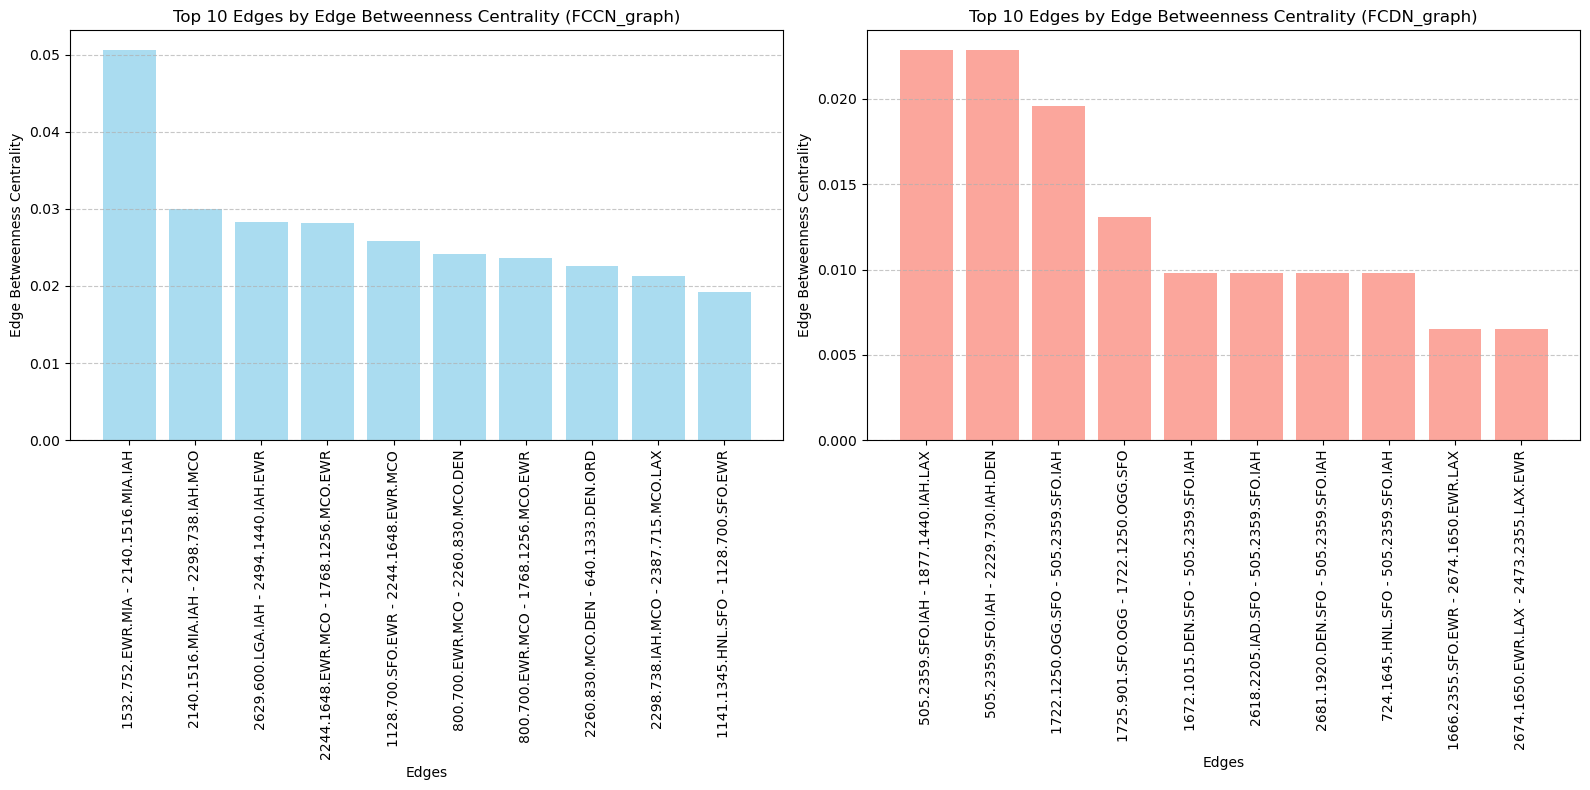

In [44]:
# Extract the top 10 edges and their edge betweenness centrality values for FCCN_graph
top_edges_fccn = sorted(nx.edge_betweenness_centrality(FCCN_graph).items(), key=lambda x: x[1], reverse=True)[:10]
edges_fccn = [f"{src} - {dest}" for (src, dest), _ in top_edges_fccn]
edge_betweenness_values_fccn = [value for _, value in top_edges_fccn]

# Extract the top 10 edges and their edge betweenness centrality values for FCDN_graph
top_edges_fcdn = sorted(nx.edge_betweenness_centrality(FCDN_graph).items(), key=lambda x: x[1], reverse=True)[:10]
edges_fcdn = [f"{src} - {dest}" for (src, dest), _ in top_edges_fcdn]
edge_betweenness_values_fcdn = [value for _, value in top_edges_fcdn]

# Create a figure with subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the top 10 edges by edge betweenness centrality for FCCN_graph
axes[0].bar(edges_fccn, edge_betweenness_values_fccn, color='skyblue', alpha=0.7)
axes[0].set_xlabel('Edges')
axes[0].set_ylabel('Edge Betweenness Centrality')
axes[0].set_title('Top 10 Edges by Edge Betweenness Centrality (FCCN_graph)')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the top 10 edges by edge betweenness centrality for FCDN_graph
axes[1].bar(edges_fcdn, edge_betweenness_values_fcdn, color='salmon', alpha=0.7)
axes[1].set_xlabel('Edges')
axes[1].set_ylabel('Edge Betweenness Centrality')
axes[1].set_title('Top 10 Edges by Edge Betweenness Centrality (FCDN_graph)')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('pdf/flight_edge_centrality.pdf')

# Show the subplots
plt.show()

### Percolation

#### Betweenness Centrality

In [45]:
# Create an empty dataframe to store removed nodes and their betweenness centrality values
removed_nodes_fccn_df = pd.DataFrame(columns=["Removed_Node", "Betweenness_Centrality"])
removed_nodes_fcdn_df = pd.DataFrame(columns=["Removed_Node", "Betweenness_Centrality"])

# Define the number of iterations
num_iterations = 10

# Create a copy of the original FCCN_graph for each iteration
temp_fccn_graph = FCCN_graph.copy()
temp_fcdn_graph = FCDN_graph.copy()

for iteration in range(num_iterations):
    # Calculate betweenness centrality for the current FCCN graph
    betweenness_centrality_fccn = nx.betweenness_centrality(temp_fccn_graph)
    
    # Calculate betweenness centrality for the current FCDN graph
    betweenness_centrality_fcdn = nx.betweenness_centrality(temp_fcdn_graph)
    
    # Find the node with the highest betweenness centrality in FCCN graph
    removed_node_fccn = max(betweenness_centrality_fccn, key=betweenness_centrality_fccn.get)
    
    # Find the node with the highest betweenness centrality in FCDN graph
    removed_node_fcdn = max(betweenness_centrality_fcdn, key=betweenness_centrality_fcdn.get)
    
    # Remove the node with the highest betweenness centrality in FCCN graph
    temp_fccn_graph.remove_node(removed_node_fccn)
    
    # Remove the node with the highest betweenness centrality in FCDN graph
    temp_fcdn_graph.remove_node(removed_node_fcdn)
    
    # Store the removed node and its corresponding betweenness centrality in the dataframes
    removed_nodes_fccn_df = pd.concat([removed_nodes_fccn_df, pd.DataFrame({"Removed_Node": [removed_node_fccn],
                                                                           "Betweenness_Centrality": [betweenness_centrality_fccn[removed_node_fccn]]})],
                                     ignore_index=True)
    
    removed_nodes_fcdn_df = pd.concat([removed_nodes_fcdn_df, pd.DataFrame({"Removed_Node": [removed_node_fcdn],
                                                                           "Betweenness_Centrality": [betweenness_centrality_fcdn[removed_node_fcdn]]})],
                                     ignore_index=True)

# Display the final dataframes for FCCN and FCDN
print("Removed Nodes and Betweenness Centrality for FCCN:")
print(removed_nodes_fccn_df)

print("\nRemoved Nodes and Betweenness Centrality for FCDN:")
print(removed_nodes_fcdn_df)

Removed Nodes and Betweenness Centrality for FCCN:
        Removed_Node  Betweenness_Centrality
0  2140.1516.MIA.IAH                0.069326
1    800.700.EWR.MCO                0.066988
2  2244.1648.EWR.MCO                0.064224
3   499.1440.BOS.EWR                0.059702
4  2494.1440.IAH.EWR                0.082982
5  2446.2158.EWR.RDU                0.053984
6  1749.1655.SFO.OGG                0.018460
7  2606.1945.ORD.LGA                0.006603
8   1933.645.SNA.ORD                0.007191
9  2208.1320.STT.IAH                0.006698

Removed Nodes and Betweenness Centrality for FCDN:
        Removed_Node  Betweenness_Centrality
0   505.2359.SFO.IAH                0.044118
1  2674.1650.EWR.LAX                0.004167
2   1162.105.BQN.EWR                0.000000
3   569.1956.EWR.BQN                0.000000
4  1190.1830.EWR.LAX                0.000000
5  2614.1245.LAX.EWR                0.000000
6  1543.1957.EWR.SJU                0.000000
7   2218.105.SJU.EWR                0.0000

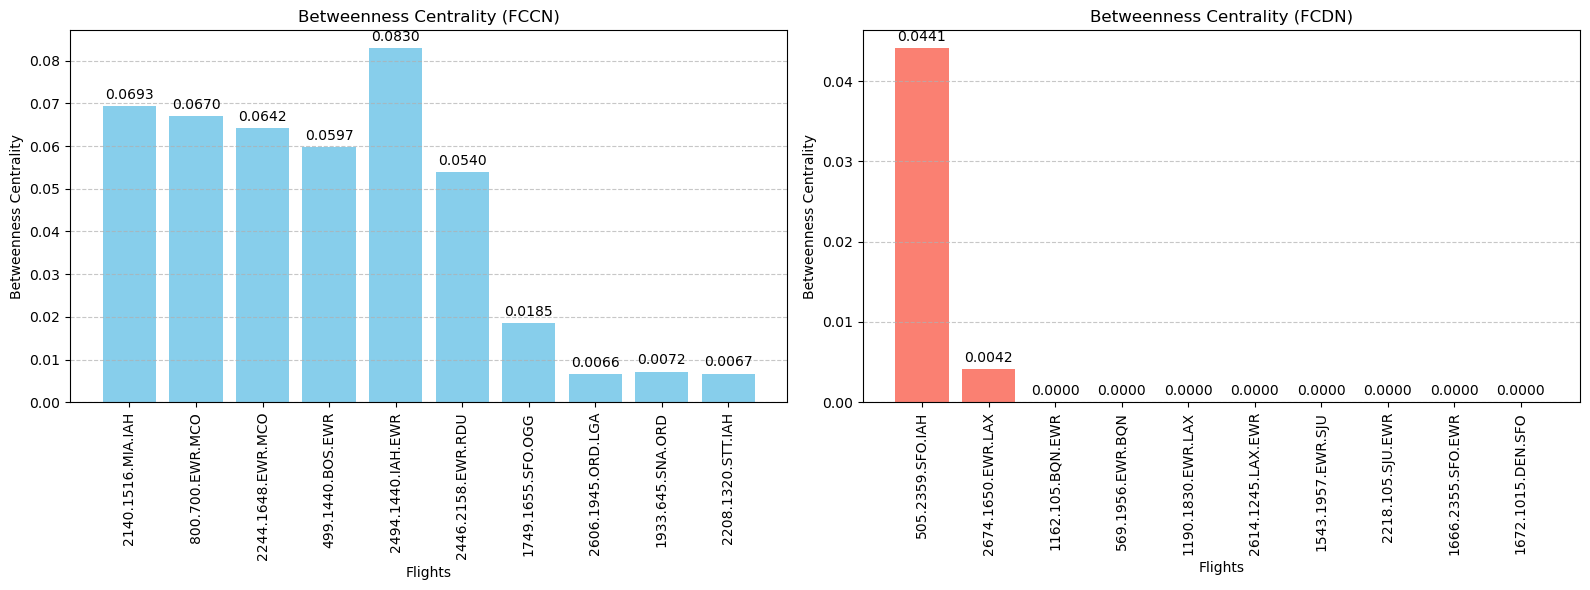

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Data for removed_nodes_df_afcn and removed_nodes_df_afdn
airports_afcn = removed_nodes_fccn_df['Removed_Node']
centrality_values_afcn = removed_nodes_fccn_df['Betweenness_Centrality']

airports_afdn = removed_nodes_fcdn_df['Removed_Node']
centrality_values_afdn = removed_nodes_fcdn_df['Betweenness_Centrality']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for removed_nodes_df_afcn
bars_afcn = axes[0].bar(airports_afcn, centrality_values_afcn, color='skyblue')
axes[0].set_title('Betweenness Centrality (FCCN)')
axes[0].set_xlabel('Flights')
axes[0].set_ylabel('Betweenness Centrality')
axes[0].set_xticklabels(airports_afcn, rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for removed_nodes_df_afdn
bars_afdn = axes[1].bar(airports_afdn, centrality_values_afdn, color='salmon')
axes[1].set_title('Betweenness Centrality (FCDN)')
axes[1].set_xlabel('Flights')
axes[1].set_ylabel('Betweenness Centrality')
axes[1].set_xticklabels(airports_afdn, rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for bar_afcn, bar_afdn in zip(bars_afcn, bars_afdn):
    height_afcn = bar_afcn.get_height()
    height_afdn = bar_afdn.get_height()
    axes[0].annotate(f'{height_afcn:.4f}', xy=(bar_afcn.get_x() + bar_afcn.get_width() / 2, height_afcn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    axes[1].annotate(f'{height_afdn:.4f}', xy=(bar_afdn.get_x() + bar_afdn.get_width() / 2, height_afdn),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('pdf/flight_percolation.pdf')
plt.show()

In [47]:
common_removed_flights_bcp = set(removed_nodes_fccn_df['Removed_Node']).intersection(removed_nodes_fcdn_df['Removed_Node'])
common_removed_flights_bcp

set()

# Disruptive Elements

**Ranking System** CN (Complete Network - Potential Disruptive Elements) vs DN (Delay Network - Actual Disruptive Elements) (Chauhan et al.)

1. If potential and actual disruptive elements overlap and the overlapped elements come up across multiple techniques (refer to table above), such as disruptive elements using percolation and disruptive elements using betweenness centrality, the disruptive elements are considered to have the highest priority and should be addressed first, to improve the airline operations. This is because these elements indicate an issue with the airline schedule.

2. If potential and actual disruptive elements overlap and the overlapped elements occur only once, it indicates an issue with the airline schedule.

3. If there is no overlap between potential and actual disruptive elements; however, some of the actual disruptive elements come up in multiple techniques, the disruptive elements need attention as they have caused disruptions in the operations.

4. If there is no overlap between potential and actual disruptive elements, and no element comes in multiple techniques, there is no major issue with the airline schedule. It is not possible to prioritize the disruptive elements in this case; however, the analysis is still useful for an expert, for identifying disruptive elements that can be prioritized.

5. If there is no overlap between potential and actual disruptive elements, and some of the potential disruptive elements occur in multiple techniques, the disruptive elements only identify the busiest elements of the network, and from the current analysis they appear to be well taken care of and do not require more attention.

## Disruptive Airports

**Ranking**

Rank 1

- 'CLE', 'DEN', 'EWR', 'HNL', 'IAD', 'IAH', 'LAX', 'ORD', 'SFO'

Rank 2

- 'MCO', 'ABQ'

Rank 3

- 'GUM'

In [48]:
print(common_airports_odc)
print(common_airports_bc)
print(common_removed_nodes_bcp)

priority_elements_afn = common_airports_odc.intersection(common_airports_bc, common_removed_nodes_bcp)
priority_elements_afn

{'MCO', 'DEN', 'IAH', 'CLE', 'IAD', 'ORD', 'HNL', 'EWR', 'LAX', 'SFO'}
{'DEN', 'IAH', 'CLE', 'IAD', 'ORD', 'HNL', 'GUM', 'EWR', 'LAX', 'SFO'}
{'ABQ', 'DEN', 'IAH', 'CLE', 'IAD', 'ORD', 'HNL', 'EWR', 'LAX', 'SFO'}


{'CLE', 'DEN', 'EWR', 'HNL', 'IAD', 'IAH', 'LAX', 'ORD', 'SFO'}

In [56]:
common_airports_odc.difference(common_airports_bc, common_removed_nodes_bcp)

{'MCO'}

In [50]:
common_airports_bc.difference(common_airports_odc, common_removed_nodes_bcp)

{'GUM'}

In [57]:
common_removed_nodes_bcp.difference(common_airports_odc, common_airports_bc)

{'ABQ'}

In [58]:
priority_elements_afn.difference(set(list_airports_odc).intersection(list_airports_bc, list_airport_bcp))


set()

## Disruptive Flights

**Disruptive Rank**

Rank 1: None

Rank 2: None

Rank 3:

- '1162.105.BQN.EWR',
- '1190.1830.EWR.LAX',
- '1543.1957.EWR.SJU',
- '1666.2355.SFO.EWR',
- '2218.105.SJU.EWR',
- '2614.1245.LAX.EWR',
- '2674.1650.EWR.LAX',
- '505.2359.SFO.IAH',
- '569.1956.EWR.BQN'

Rank 4:

- '1044.700.MFE.IAH', '1128.700.SFO.EWR', '1162.105.BQN.EWR', '1181.600.LAS.IAH', '1190.1830.EWR.LAX',, '1532.752.EWR.MIA',, '1543.1957.EWR.SJU',, '1666.2355.SFO.EWR',, '1672.1015.DEN.SFO',, '1722.1250.OGG.SFO',, '1749.1655.SFO.OGG',, '1768.1256.MCO.EWR',, '1799.900.MIA.EWR',, '1923.1659.LAS.IAH',, '1933.645.SNA.ORD',, '2092.1903.MIA.IAH',, '2140.1516.MIA.IAH',, '2167.545.MSP.IAH',, '2208.1320.STT.IAH',, '2218.105.SJU.EWR',, '2244.1648.EWR.MCO',, '2298.738.IAH.MCO',, '2446.2158.EWR.RDU',, '2447.700.RSW.EWR',, '2494.1440.IAH.EWR',, '2606.1945.ORD.LGA',, '2614.1245.LAX.EWR',, '2629.600.LGA.IAH',, '2674.1650.EWR.LAX',, '499.1440.BOS.EWR',, '505.2359.SFO.IAH',, '569.1956.EWR.BQN',, '715.1210.SAN.IAH',, '800.700.EWR.MCO'

Rank 5:

- 2494.1440.IAH.EWR


In [59]:
list_bcp = removed_nodes_fcdn_df['Removed_Node'].tolist()
list_bcc = removed_nodes_fccn_df['Removed_Node'].tolist()

set(list_odc).intersection(list_bc, list_bcp)

{'1162.105.BQN.EWR',
 '1190.1830.EWR.LAX',
 '1543.1957.EWR.SJU',
 '1666.2355.SFO.EWR',
 '2218.105.SJU.EWR',
 '2614.1245.LAX.EWR',
 '2674.1650.EWR.LAX',
 '505.2359.SFO.IAH',
 '569.1956.EWR.BQN'}

In [60]:
set(list_bc).intersection(list_odc, list_bcp)

{'1162.105.BQN.EWR',
 '1190.1830.EWR.LAX',
 '1543.1957.EWR.SJU',
 '1666.2355.SFO.EWR',
 '2218.105.SJU.EWR',
 '2614.1245.LAX.EWR',
 '2674.1650.EWR.LAX',
 '505.2359.SFO.IAH',
 '569.1956.EWR.BQN'}

In [61]:
set(list_bcp).intersection(list_odc, list_bc)

{'1162.105.BQN.EWR',
 '1190.1830.EWR.LAX',
 '1543.1957.EWR.SJU',
 '1666.2355.SFO.EWR',
 '2218.105.SJU.EWR',
 '2614.1245.LAX.EWR',
 '2674.1650.EWR.LAX',
 '505.2359.SFO.IAH',
 '569.1956.EWR.BQN'}

In [65]:
set(list_odc).intersection(list_bc, list_bcp)

{'1162.105.BQN.EWR',
 '1190.1830.EWR.LAX',
 '1543.1957.EWR.SJU',
 '1666.2355.SFO.EWR',
 '2218.105.SJU.EWR',
 '2614.1245.LAX.EWR',
 '2674.1650.EWR.LAX',
 '505.2359.SFO.IAH',
 '569.1956.EWR.BQN'}

In [66]:
list3 = set(list_odc).intersection(list_bc, list_bcp)
list3

{'1162.105.BQN.EWR',
 '1190.1830.EWR.LAX',
 '1543.1957.EWR.SJU',
 '1666.2355.SFO.EWR',
 '2218.105.SJU.EWR',
 '2614.1245.LAX.EWR',
 '2674.1650.EWR.LAX',
 '505.2359.SFO.IAH',
 '569.1956.EWR.BQN'}

In [69]:
list_rest = set(list_odc).union(list_bc, list_bcp, list_odp, list_bca, list_bcc)
list_rest

{'1044.700.MFE.IAH',
 '1128.700.SFO.EWR',
 '1162.105.BQN.EWR',
 '1181.600.LAS.IAH',
 '1190.1830.EWR.LAX',
 '1532.752.EWR.MIA',
 '1543.1957.EWR.SJU',
 '1666.2355.SFO.EWR',
 '1672.1015.DEN.SFO',
 '1722.1250.OGG.SFO',
 '1749.1655.SFO.OGG',
 '1768.1256.MCO.EWR',
 '1799.900.MIA.EWR',
 '1923.1659.LAS.IAH',
 '1933.645.SNA.ORD',
 '2092.1903.MIA.IAH',
 '2140.1516.MIA.IAH',
 '2167.545.MSP.IAH',
 '2208.1320.STT.IAH',
 '2218.105.SJU.EWR',
 '2244.1648.EWR.MCO',
 '2298.738.IAH.MCO',
 '2446.2158.EWR.RDU',
 '2447.700.RSW.EWR',
 '2494.1440.IAH.EWR',
 '2606.1945.ORD.LGA',
 '2614.1245.LAX.EWR',
 '2629.600.LGA.IAH',
 '2674.1650.EWR.LAX',
 '499.1440.BOS.EWR',
 '505.2359.SFO.IAH',
 '569.1956.EWR.BQN',
 '715.1210.SAN.IAH',
 '800.700.EWR.MCO'}

In [72]:
list4 = set(list_odp).intersection(list_bca, list_bcc)
list4

{'2140.1516.MIA.IAH', '2494.1440.IAH.EWR'}

In [73]:
list_rest.difference(list3, list4)

{'1044.700.MFE.IAH',
 '1128.700.SFO.EWR',
 '1181.600.LAS.IAH',
 '1532.752.EWR.MIA',
 '1672.1015.DEN.SFO',
 '1722.1250.OGG.SFO',
 '1749.1655.SFO.OGG',
 '1768.1256.MCO.EWR',
 '1799.900.MIA.EWR',
 '1923.1659.LAS.IAH',
 '1933.645.SNA.ORD',
 '2092.1903.MIA.IAH',
 '2167.545.MSP.IAH',
 '2208.1320.STT.IAH',
 '2244.1648.EWR.MCO',
 '2298.738.IAH.MCO',
 '2446.2158.EWR.RDU',
 '2447.700.RSW.EWR',
 '2606.1945.ORD.LGA',
 '2629.600.LGA.IAH',
 '499.1440.BOS.EWR',
 '715.1210.SAN.IAH',
 '800.700.EWR.MCO'}